# Gradient-based optimisation using _Cheetah_ and _PyTorch_

_Cheetah_ is a differentiable beam dynamics simulation engine, making it ideally suited to gradient-based optimisation, for example for optimisation magnet settings, lattice geometries or even for system identification. _Cheetah_'s tight integration with _PyTorch_ makes this particularly easy as it opens up the use of _PyTorch_'s automatic differentiation capabilities and toolchain.

In this example, we demonstrate how to use _Cheetah_ for **magnet setting optimisation** and how to **add custom normalisation** to that same task.


In [1]:
from typing import Dict, Optional

import cheetah
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)

In [3]:
plt.style.use(["science", "ieee", "no-latex"])

## Simple example (without normalisation)

We start by creating the lattice section and incoming beam.


In [4]:
ares_ea = cheetah.Segment.from_lattice_json("ARESlatticeStage3v1_9.json").subcell(
    "AREASOLA1", "AREABSCR1"
)

In [5]:
incoming_beam = cheetah.ParticleBeam.from_astra("ACHIP_EA1_2021.1351.001")
incoming_beam

ParticleBeam(n=100000, mu_x=tensor(8.2413e-07), mu_px=tensor(5.9885e-08), mu_y=tensor(-1.7276e-06), mu_py=tensor(-1.1746e-07), sigma_x=tensor(0.0002), sigma_px=tensor(3.6794e-06), sigma_y=tensor(0.0002), sigma_py=tensor(3.6941e-06), sigma_tau=tensor(8.0116e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)) total_charge=tensor(5.0000e-13))

By default, _Cheetah_ assumes that no part of its simulation requires differentiation and therefore does not track gradients, all parameters are of type `torch.Tensor`. To enable gradient tracking for parameters you would like to optimise over, you need to wrap them in `torch.nn.Parameter`, either when creating your elements and beams, or later on.

In this example, we would like to optimise over the settings of three quadrupoles and two steerers in the experimental area at the _ARES_ accelerator facility at DESY. In this case, we will need to redefine the `k1` and `angle` parameters of the magnets as `torch.nn.Parameter`.

**Note:** You could simply wrap the value of the parameters as the value it already has, e.g.

```python
ares_ea.AREAMQZM1.k1 = nn.Parameter(ares_ea.AREAMQZM1.k1)
```


In [6]:
ares_ea.AREAMQZM1.k1 = nn.Parameter(ares_ea.AREAMQZM1.k1)
ares_ea.AREAMQZM2.k1 = nn.Parameter(ares_ea.AREAMQZM2.k1)
ares_ea.AREAMCVM1.angle = nn.Parameter(ares_ea.AREAMCVM1.angle)
ares_ea.AREAMQZM3.k1 = nn.Parameter(ares_ea.AREAMQZM3.k1)
ares_ea.AREAMCHM1.angle = nn.Parameter(ares_ea.AREAMCHM1.angle)

Next, we define the function that will do the actual optimisation. The goal of our optimisation is to tune the transverse beam parameters `[mu_x, sigma_x, mu_y, sigma_y]` towards some target beam parameters on a diagnostic screen at the end of the considered lattice segment. Hence, we pass the target beam parameters to the `train` function and make use of _PyTorch_'s `torch.nn.function.mse_loss` function. Note that we can easily make use of _PyTorch_'s `Adam` optimiser implementation. As a result the following code looks very similar to a standard _PyTorch_ optimisation loop for the training of neural networks.


In [7]:
def train(num_steps: int, target_beam_parameters: torch.Tensor, lr=0.1) -> dict:
    beam_parameter_history = []
    magnet_setting_history = []
    loss_history = []

    optimizer = torch.optim.Adam(ares_ea.parameters(), lr=lr)

    for _ in range(num_steps):
        optimizer.zero_grad()

        outgoing_beam = ares_ea.track(incoming_beam)

        observed_beam_parameters = torch.stack(
            [
                outgoing_beam.mu_x,
                outgoing_beam.sigma_x,
                outgoing_beam.mu_y,
                outgoing_beam.sigma_y,
            ]
        )
        loss = F.mse_loss(observed_beam_parameters, target_beam_parameters)

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(observed_beam_parameters.detach().numpy())
        magnet_setting_history.append(
            torch.stack(
                [
                    ares_ea.AREAMQZM1.k1,
                    ares_ea.AREAMQZM2.k1,
                    ares_ea.AREAMCVM1.angle,
                    ares_ea.AREAMQZM3.k1,
                    ares_ea.AREAMCHM1.angle,
                ]
            )
            .detach()
            .numpy()
        )
        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "magnet_settings": magnet_setting_history,
    }
    return history

We now simply run the optimisation function with a target beam that is centred on the origin and focused to be as small as possible.


In [8]:
history = train(num_steps=100, target_beam_parameters=torch.zeros(4))

The returned `history` dictionary allows us to plot the evolution of the optimisation process.


In [9]:
def plot_history(
    history: Dict,
    save_path: Optional[str] = None,
):
    fig, axs = plt.subplots(4, 1, figsize=(3.5, 5), sharex=True)

    axs[0].plot(history["loss"])
    axs[0].set_ylabel("Loss")

    axs[1].plot(
        [record[0] * 1e3 for record in history["beam_parameters"]],
        label=r"$\mu_x$",
        c="#369F2D",
    )
    axs[1].plot(
        [record[1] * 1e3 for record in history["beam_parameters"]],
        label=r"$\sigma_x$",
        c="#EE4431",
    )
    axs[1].plot(
        [record[2] * 1e3 for record in history["beam_parameters"]],
        label=r"$\mu_y$",
        c="#1663A9",
    )
    axs[1].plot(
        [record[3] * 1e3 for record in history["beam_parameters"]],
        label=r"$\sigma_y$",
        c="#8E549E",
    )
    axs[1].set_ylabel("Beam\nparameter (mm)")
    axs[1].legend(ncol=2)

    axs[2].plot(
        [record[0] for record in history["magnet_settings"]],
        label=r"$Q_1$",
        c="#FFD700",
    )
    axs[2].plot(
        [record[1] for record in history["magnet_settings"]],
        label=r"$Q_2$",
        c="#40E0D0",
    )
    axs[2].plot(
        [record[3] for record in history["magnet_settings"]],
        label=r"$Q_3$",
        c="#FF7E5F",
    )
    axs[2].set_ylabel("Quadrupole\n" + r"strength ($m^{-2}$)")
    axs[2].legend(ncol=3, loc="lower right")

    axs[3].plot(
        [record[2] * 1e3 for record in history["magnet_settings"]],
        label=r"$C_v$",
        c="#9e9e9e",
    )
    axs[3].plot(
        [record[4] * 1e3 for record in history["magnet_settings"]],
        label=r"$C_h$",
        c="#33bbee",
    )
    axs[3].set_xlabel("Iteration")
    axs[3].set_ylabel("Steering\nangle (mrad)")
    axs[3].legend(ncol=2)

    subfig_labels = ["(a)", "(b)", "(c)", "(d)"]
    for ax, label in zip(axs, subfig_labels):
        ax.text(x=0.92, y=0.65, s=label, transform=ax.transAxes)

    fig.align_ylabels(axs)
    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path)

    plt.show()

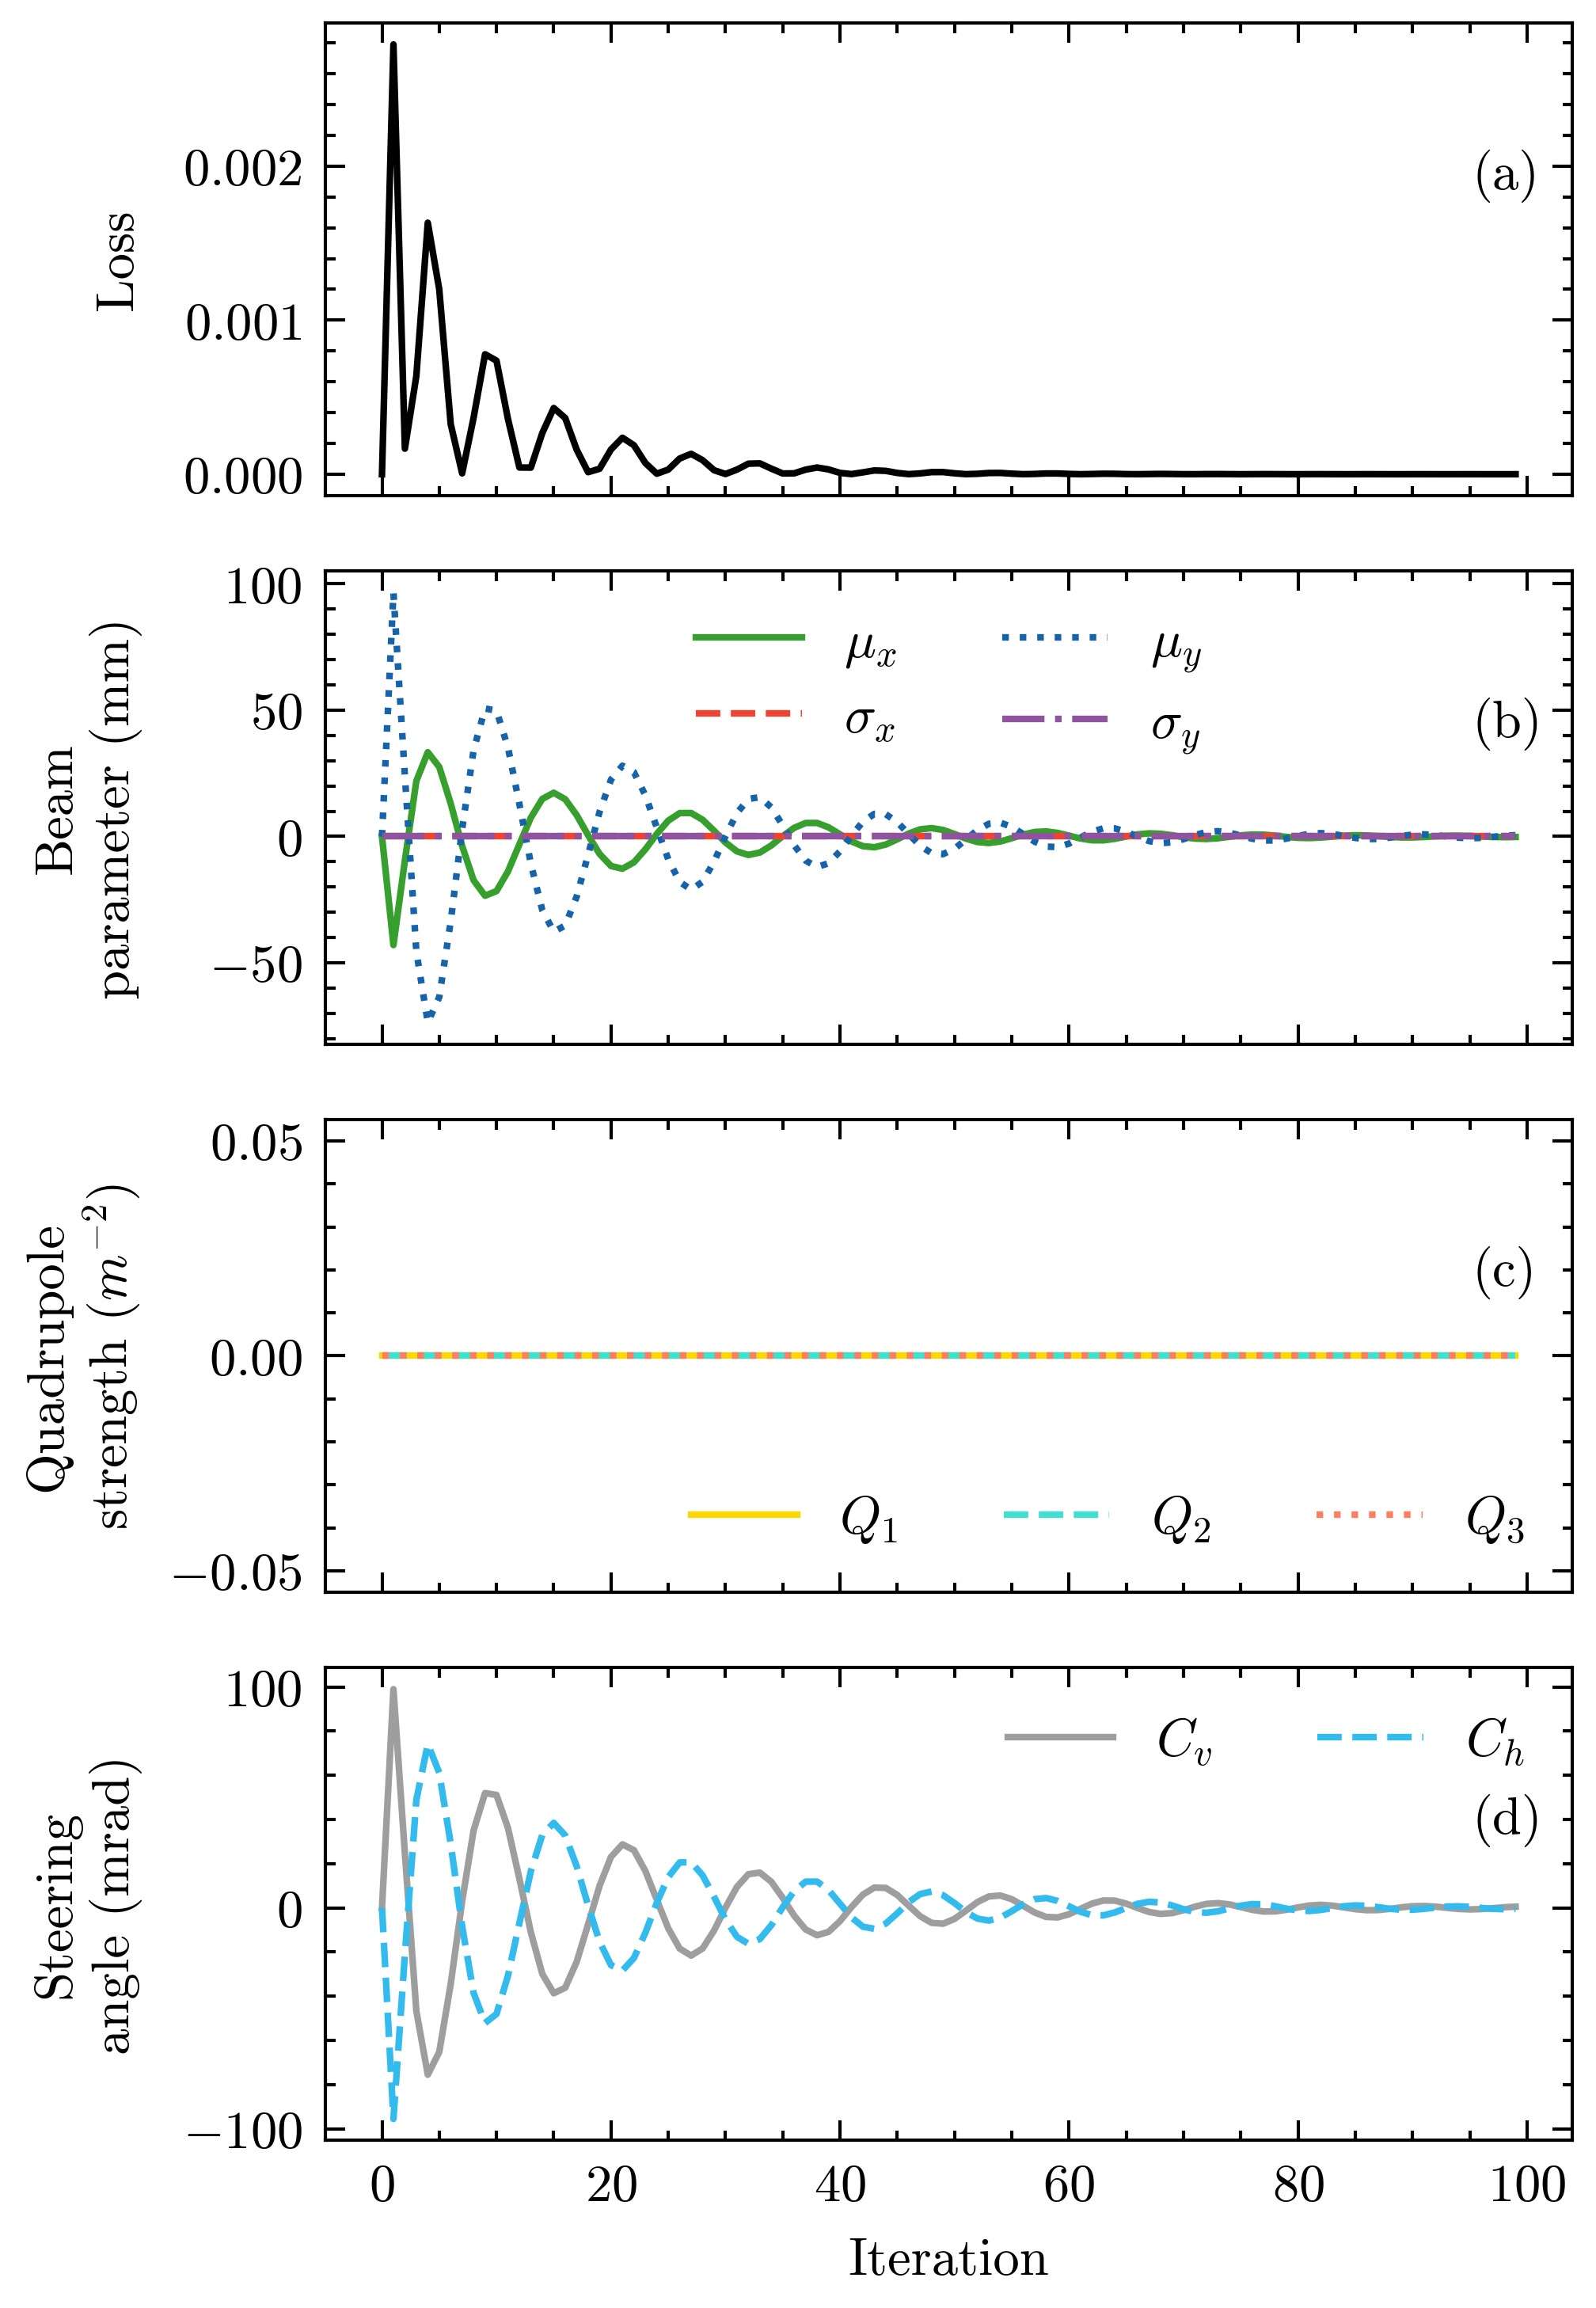

In [10]:
plot_history(history)

Success! 🎉 We can observe that the optimisation converges to a solution that is close to the target beam parameters.

**However**, we can also observe that the quadrupole converges very slowly, indicating that the learning rate is too small, while the steerers keep overshooting the target, indicating that the learning rate is too large. This is a common problem in gradient-based optimisation caused by the very different scales of `k1` and `angle`, and can be solved by **normalising** the parameters under optimisation.

## Normalising parameters in gradient-based optimisation

In the following example we demonstrate how to **normalise** the parameters under optimisation with _Cheetah_. The same principle can also be applied to other custom mechanisms one might like to build around the lattice optimisation process, e.g. to add custom constraints, coupled parameters, etc.

To achieve this, we wrap the lattice section in a `torch.nn.Module` and define a `forward` function that applies the normalisation to the parameters before passing them to the lattice section.

**Note** that this time, simply for the fun of it, we also start with randomly initialised magnet settings.


In [11]:
class NormalizedARESExperimentalArea(nn.Module):
    """
    Wrapper around the AREA experimental area that holds normalised versions of the
    magnet settings as its trainable parameters.
    """

    QUADRUPOLE_LIMIT = 5.0
    STEERER_LIMIT = 6.1782e-3

    def __init__(self) -> None:
        super().__init__()

        self.ares_ea = cheetah.Segment.from_lattice_json(
            "ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        # self.normalized_quadrupole_strengths = nn.Parameter(
        #     torch.tensor([10.0, -10.0, 10.0]) / self.QUADRUPOLE_LIMIT
        # )
        # self.normalized_steering_angles = nn.Parameter(
        #     torch.tensor([1e-3, -1e-3]) / self.STEERER_LIMIT
        # )

        self.normalized_quadrupole_strengths = nn.Parameter(torch.randn(3) * 2 - 1)
        self.normalized_steering_angles = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, incoming_beam: cheetah.Beam):
        self.ares_ea.AREAMQZM1.k1 = (
            self.normalized_quadrupole_strengths[0] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMQZM2.k1 = (
            self.normalized_quadrupole_strengths[1] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMCVM1.angle = (
            self.normalized_steering_angles[0] * self.STEERER_LIMIT
        )
        self.ares_ea.AREAMQZM3.k1 = (
            self.normalized_quadrupole_strengths[2] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMCHM1.angle = (
            self.normalized_steering_angles[1] * self.STEERER_LIMIT
        )

        return self.ares_ea.track(incoming_beam)

In [12]:
normalized_ares_ea = NormalizedARESExperimentalArea()

We then redefine the `train` function to use the `torch.nn.Module` instead of the lattice section directly.

**Note** that we also chose to apply normalisation to the beam parameters. This is not strictly necessary, but can help to improve the stability of the optimisation process.


In [13]:
def train_normalized(num_steps: int, target_beam_parameters: torch.Tensor) -> dict:
    beam_parameter_history = []
    magnet_setting_history = []
    loss_history = []

    optimizer = torch.optim.Adam(normalized_ares_ea.parameters(), lr=1e-1)

    for _ in range(num_steps):
        optimizer.zero_grad()

        outgoing_beam = normalized_ares_ea(incoming_beam)
        observed_beam_parameters = torch.stack(
            [
                outgoing_beam.mu_x,
                outgoing_beam.sigma_x,
                outgoing_beam.mu_y,
                outgoing_beam.sigma_y,
            ]
        )
        loss = F.mse_loss(
            observed_beam_parameters / 2e-3, target_beam_parameters / 2e-3
        )

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(observed_beam_parameters.detach().numpy())
        magnet_setting_history.append(
            torch.stack(
                [
                    normalized_ares_ea.ares_ea.AREAMQZM1.k1,
                    normalized_ares_ea.ares_ea.AREAMQZM2.k1,
                    normalized_ares_ea.ares_ea.AREAMCVM1.angle,
                    normalized_ares_ea.ares_ea.AREAMQZM3.k1,
                    normalized_ares_ea.ares_ea.AREAMCHM1.angle,
                ]
            )
            .detach()
            .numpy()
        )

        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "magnet_settings": magnet_setting_history,
    }
    return history

Now we run or new `train_normalized` function with the same target beam as before.


In [14]:
history = train_normalized(num_steps=200, target_beam_parameters=torch.zeros(4))

Then we plot the evolution of the optimisation process again.


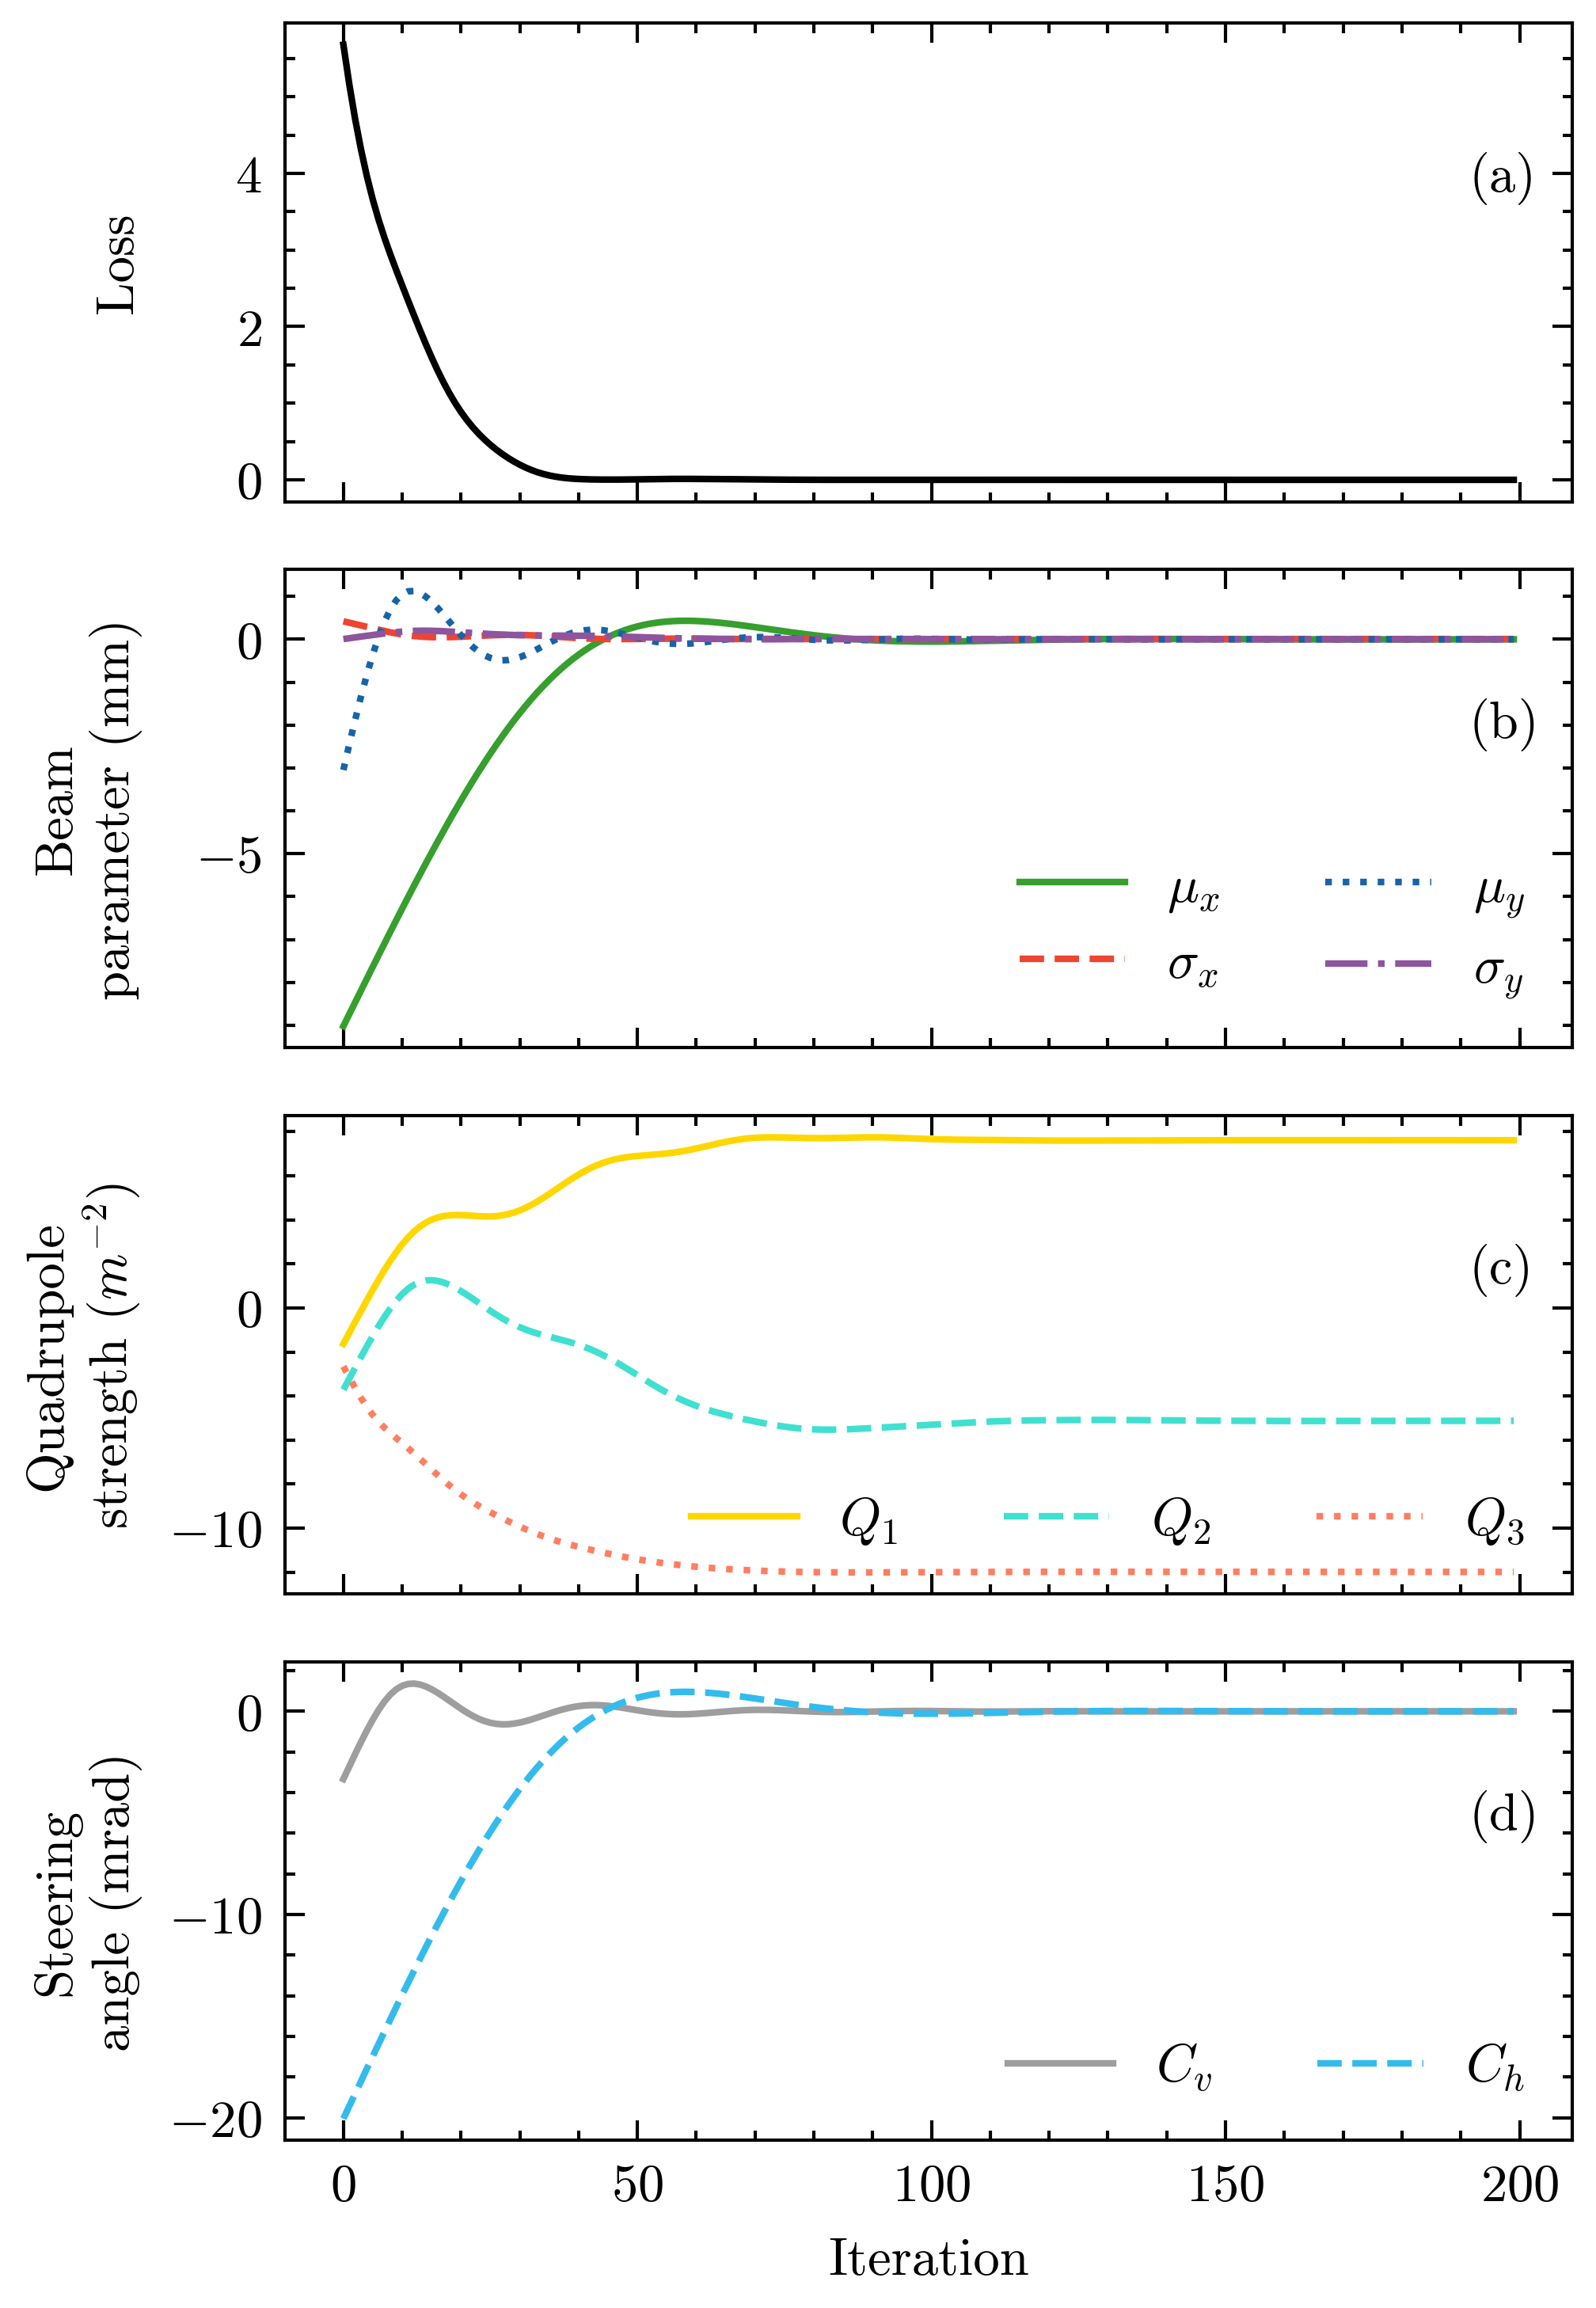

In [15]:
plot_history(history, save_path="tuning_convergence_example.pdf")

As you can see this already looks much better than it did without normalisation.


In [16]:
history["beam_parameters"][-1]

print(
    f"""Final deviations from the target beam parameters:
mu_x: {history["beam_parameters"][-1][0] * 1e6:.2f} μm
sigma_x: {history["beam_parameters"][-1][1] * 1e6:.2f} μm
mu_y: {history["beam_parameters"][-1][2] * 1e6:.2f} μm
sigma_y: {history["beam_parameters"][-1][3] * 1e6:.2f} μm

Mean absolute deviation: {np.mean(np.abs(history["beam_parameters"][-1])) * 1e6:.2f} μm
"""
)

Final deviations from the target beam parameters:
mu_x: 0.33 μm
sigma_x: 6.66 μm
mu_y: -0.07 μm
sigma_y: 0.85 μm

Mean absolute deviation: 1.98 μm



In [ ]:
import pickle
from typing import Iterator, Literal, Optional

import cheetah
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
import torch.nn.functional as F
from icecream import ic
from sklearn.utils import shuffle
from torch import nn
from tqdm import trange

In [2]:
torch.manual_seed(42)

In [3]:
plt.style.use(["science", "ieee", "no-latex"])

In [4]:
# Load data from two different runs

with open("rl_firstsub_real_32.pkl", "rb") as f:
    rl_data = pickle.load(f)

with open("bo_firstsub_real_32.pkl", "rb") as f:
    bo_data = pickle.load(f)

with open("rl_sim_33.pkl", "rb") as f:
    rl_data_sim = pickle.load(f)

In [5]:
len(rl_data["observations"]), len(rl_data_sim["observations"])

(51, 151)

In [6]:
real_combined = {"observations": rl_data["observations"] + bo_data["observations"]}

In [7]:
# Load ARES lattice and wrap it in normalisation nn.Module


class NormalizedARESEAMisalignments(nn.Module):
    """
    Wrapper around the ARES experimental area lattice that normalises the
    quadrupole misalignments.
    """

    MAX_MISALIGNMENT = 0.5e-3  # 0.5 mm

    def __init__(
        self,
        incoming: Literal[
            "rl_sim_data", "centered_rl_sim_data", "centered_astra", "uncentered_astra"
        ] = "centered_astra",
    ):
        super().__init__()

        self.ares_ea = cheetah.Segment.from_lattice_json(
            "ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        # Load a beam that's close to a design beam and move it to zero mu. Zero mu is
        # assumed because we need to define origin somehow and at ARES ballistic
        # trajectory is preferred.
        if incoming == "rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0], dtype=torch.float32),
                mu_x=torch.tensor(incoming_parameters[1], dtype=torch.float32),
                mu_px=torch.tensor(incoming_parameters[2], dtype=torch.float32),
                mu_y=torch.tensor(incoming_parameters[3], dtype=torch.float32),
                mu_py=torch.tensor(incoming_parameters[4], dtype=torch.float32),
                sigma_x=torch.tensor(incoming_parameters[5], dtype=torch.float32),
                sigma_px=torch.tensor(incoming_parameters[6], dtype=torch.float32),
                sigma_y=torch.tensor(incoming_parameters[7], dtype=torch.float32),
                sigma_py=torch.tensor(incoming_parameters[8], dtype=torch.float32),
                sigma_tau=torch.tensor(incoming_parameters[9], dtype=torch.float32),
                sigma_p=torch.tensor(incoming_parameters[10], dtype=torch.float32),
            )
        elif incoming == "centered_rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0], dtype=torch.float32),
                mu_x=torch.tensor(0.0),
                mu_px=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_py=torch.tensor(0.0),
                sigma_x=torch.tensor(incoming_parameters[5], dtype=torch.float32),
                sigma_px=torch.tensor(incoming_parameters[6], dtype=torch.float32),
                sigma_y=torch.tensor(incoming_parameters[7], dtype=torch.float32),
                sigma_py=torch.tensor(incoming_parameters[8], dtype=torch.float32),
                sigma_tau=torch.tensor(incoming_parameters[9], dtype=torch.float32),
                sigma_p=torch.tensor(incoming_parameters[10], dtype=torch.float32),
            )
        elif incoming == "centered_astra":
            self.incoming_beam = cheetah.ParameterBeam.from_astra(
                "ACHIP_EA1_2021.1351.001"
            ).transformed_to(
                mu_x=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_px=torch.tensor(0.0),
                mu_py=torch.tensor(0.0),
            )
        elif incoming == "uncentered_astra":
            rl_sim_incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_astra(
                "ACHIP_EA1_2021.1351.001"
            ).transformed_to(
                mu_x=torch.tensor(rl_sim_incoming_parameters[1], dtype=torch.float32),
                mu_px=torch.tensor(rl_sim_incoming_parameters[2], dtype=torch.float32),
                mu_y=torch.tensor(rl_sim_incoming_parameters[3], dtype=torch.float32),
                mu_py=torch.tensor(rl_sim_incoming_parameters[4], dtype=torch.float32),
            )
        else:
            raise ValueError(f"Unknown incoming beam {incoming}")

        self.normalized_misalignments_q1 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q2 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q3 = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, magnet_settings):
        # Set the magnet settings as they were in the ground truth sample
        self.ares_ea.AREAMQZM1.k1 = magnet_settings[..., 0]
        self.ares_ea.AREAMQZM2.k1 = magnet_settings[..., 1]
        self.ares_ea.AREAMCVM1.angle = magnet_settings[..., 2]
        self.ares_ea.AREAMQZM3.k1 = magnet_settings[..., 3]
        self.ares_ea.AREAMCHM1.angle = magnet_settings[..., 4]

        # Set the misalignments based on the normalised misalignments
        self.ares_ea.AREAMQZM1.misalignment = (
            self.normalized_misalignments_q1 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM2.misalignment = (
            self.normalized_misalignments_q2 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM3.misalignment = (
            self.normalized_misalignments_q3 * self.MAX_MISALIGNMENT
        )

        return self.ares_ea.track(self.incoming_beam)

In [8]:
def tensor_batched(tensor: torch.Tensor, batch_size: int) -> Iterator[torch.Tensor]:
    """Yield batched slices of a tensor with a given batch size."""
    for i in range(0, tensor.size(0), batch_size):
        yield tensor[i : i + batch_size]

In [9]:
def train_normalized(model: nn.Module, num_epochs: int, data: dict) -> dict:
    misalignment_q1_history = []
    misalignment_q2_history = []
    misalignment_q3_history = []
    beam_parameter_history = []
    loss_history = []

    magnet_settings = torch.tensor([obs["magnets"] for obs in data["observations"]])
    measured_beams = torch.tensor([obs["beam"] for obs in data["observations"]])

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for _ in trange(num_epochs):
        epoch_misalignment_q1_history = []
        epoch_misalignment_q2_history = []
        epoch_misalignment_q3_history = []
        epoch_beam_parameter_history = []
        epoch_loss_history = []

        magnet_settings, measured_beams = shuffle(magnet_settings, measured_beams)
        magnet_settings_2, measured_beams_2 = shuffle(magnet_settings, measured_beams)

        optimizer.zero_grad()

        for (
            magnet_setting_batch,
            measured_beam_batch,
            magnet_setting_2_batch,
            measured_beam_2_batch,
        ) in zip(
            tensor_batched(magnet_settings, 10),
            tensor_batched(measured_beams, 10),
            tensor_batched(magnet_settings_2, 10),
            tensor_batched(measured_beams_2, 10),
        ):
            outgoing_beam_batch = model(magnet_setting_batch)
            simulated_beam_batch = torch.stack(
                [outgoing_beam_batch.mu_x, outgoing_beam_batch.mu_y], dim=1
            )
            outgoing_beam_2_batch = model(magnet_setting_2_batch)
            simulated_beam_2_batch = torch.stack(
                [outgoing_beam_2_batch.mu_x, outgoing_beam_2_batch.mu_y], dim=1
            )
            measured_beam_change_batch = (measured_beam_2_batch - measured_beam_batch)[
                :, [0, 2]
            ]
            simulated_beam_change_batch = simulated_beam_2_batch - simulated_beam_batch
            loss = F.mse_loss(
                simulated_beam_change_batch / 2e-3, measured_beam_change_batch / 2e-3
            )

            loss.backward()

            optimizer.step()

            epoch_loss_history.append(loss.detach().numpy())
            epoch_beam_parameter_history.append(simulated_beam_batch.detach().numpy())
            epoch_misalignment_q1_history.append(
                model.ares_ea.AREAMQZM1.misalignment.detach().numpy()
            )
            epoch_misalignment_q2_history.append(
                model.ares_ea.AREAMQZM2.misalignment.detach().numpy()
            )
            epoch_misalignment_q3_history.append(
                model.ares_ea.AREAMQZM3.misalignment.detach().numpy()
            )

        # Log epoch history
        loss_history.append(np.mean(epoch_loss_history))
        beam_parameter_history.append(
            np.mean(np.vstack(epoch_beam_parameter_history), axis=0)
        )
        misalignment_q1_history.append(
            np.mean(np.stack(epoch_misalignment_q1_history), axis=0)
        )
        misalignment_q2_history.append(
            np.mean(np.stack(epoch_misalignment_q2_history), axis=0)
        )
        misalignment_q3_history.append(
            np.mean(np.stack(epoch_misalignment_q3_history), axis=0)
        )

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "misalignment_q1": misalignment_q1_history,
        "misalignment_q2": misalignment_q2_history,
        "misalignment_q3": misalignment_q3_history,
    }
    return history

In [10]:
def plot_training(
    history: dict,
    ground_truth: Optional[np.ndarray] = None,
    save_path: Optional[str] = None,
) -> None:
    fig, axs = plt.subplots(3, 1, figsize=(3.5, 3.8), sharex=True)

    axs[0].plot(history["loss"])
    axs[0].set_ylabel("Loss")

    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FF6F61",
    )
    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#6B5B95",
    )
    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#88B04B",
    )
    if ground_truth is not None:
        axs[1].axhline(
            ground_truth[0] * 1e3, color="tab:blue", linestyle="--", c="#FF6F61"
        )
        axs[1].axhline(
            ground_truth[2] * 1e3, color="tab:orange", linestyle="--", c="#6B5B95"
        )
        axs[1].axhline(
            ground_truth[4] * 1e3, color="tab:green", linestyle="--", c="#88B04B"
        )
    axs[1].set_ylabel("x misalignment (mm)")
    axs[1].legend(ncol=3)

    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FFD700",
    )
    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#40E0D0",
    )
    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#FF7E5F",
    )
    if ground_truth is not None:
        axs[2].axhline(
            ground_truth[1] * 1e3, color="tab:blue", linestyle="--", c="#FFD700"
        )
        axs[2].axhline(
            ground_truth[3] * 1e3, color="tab:orange", linestyle="--", c="#40E0D0"
        )
        axs[2].axhline(
            ground_truth[5] * 1e3, color="tab:green", linestyle="--", c="#FF7E5F"
        )
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("y misalignment (mm)")
    axs[2].legend(ncol=3)

    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path)

    plt.show()

In [11]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_1 = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)

/var/folders/z8/vzg_1dr50gg1zchydp1styc00000gn/T/ipykernel_91893/2243841168.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  magnet_settings = torch.tensor([obs["magnets"] for obs in data["observations"]])
100%|██████████| 1500/1500 [00:51<00:00, 29.36it/s]


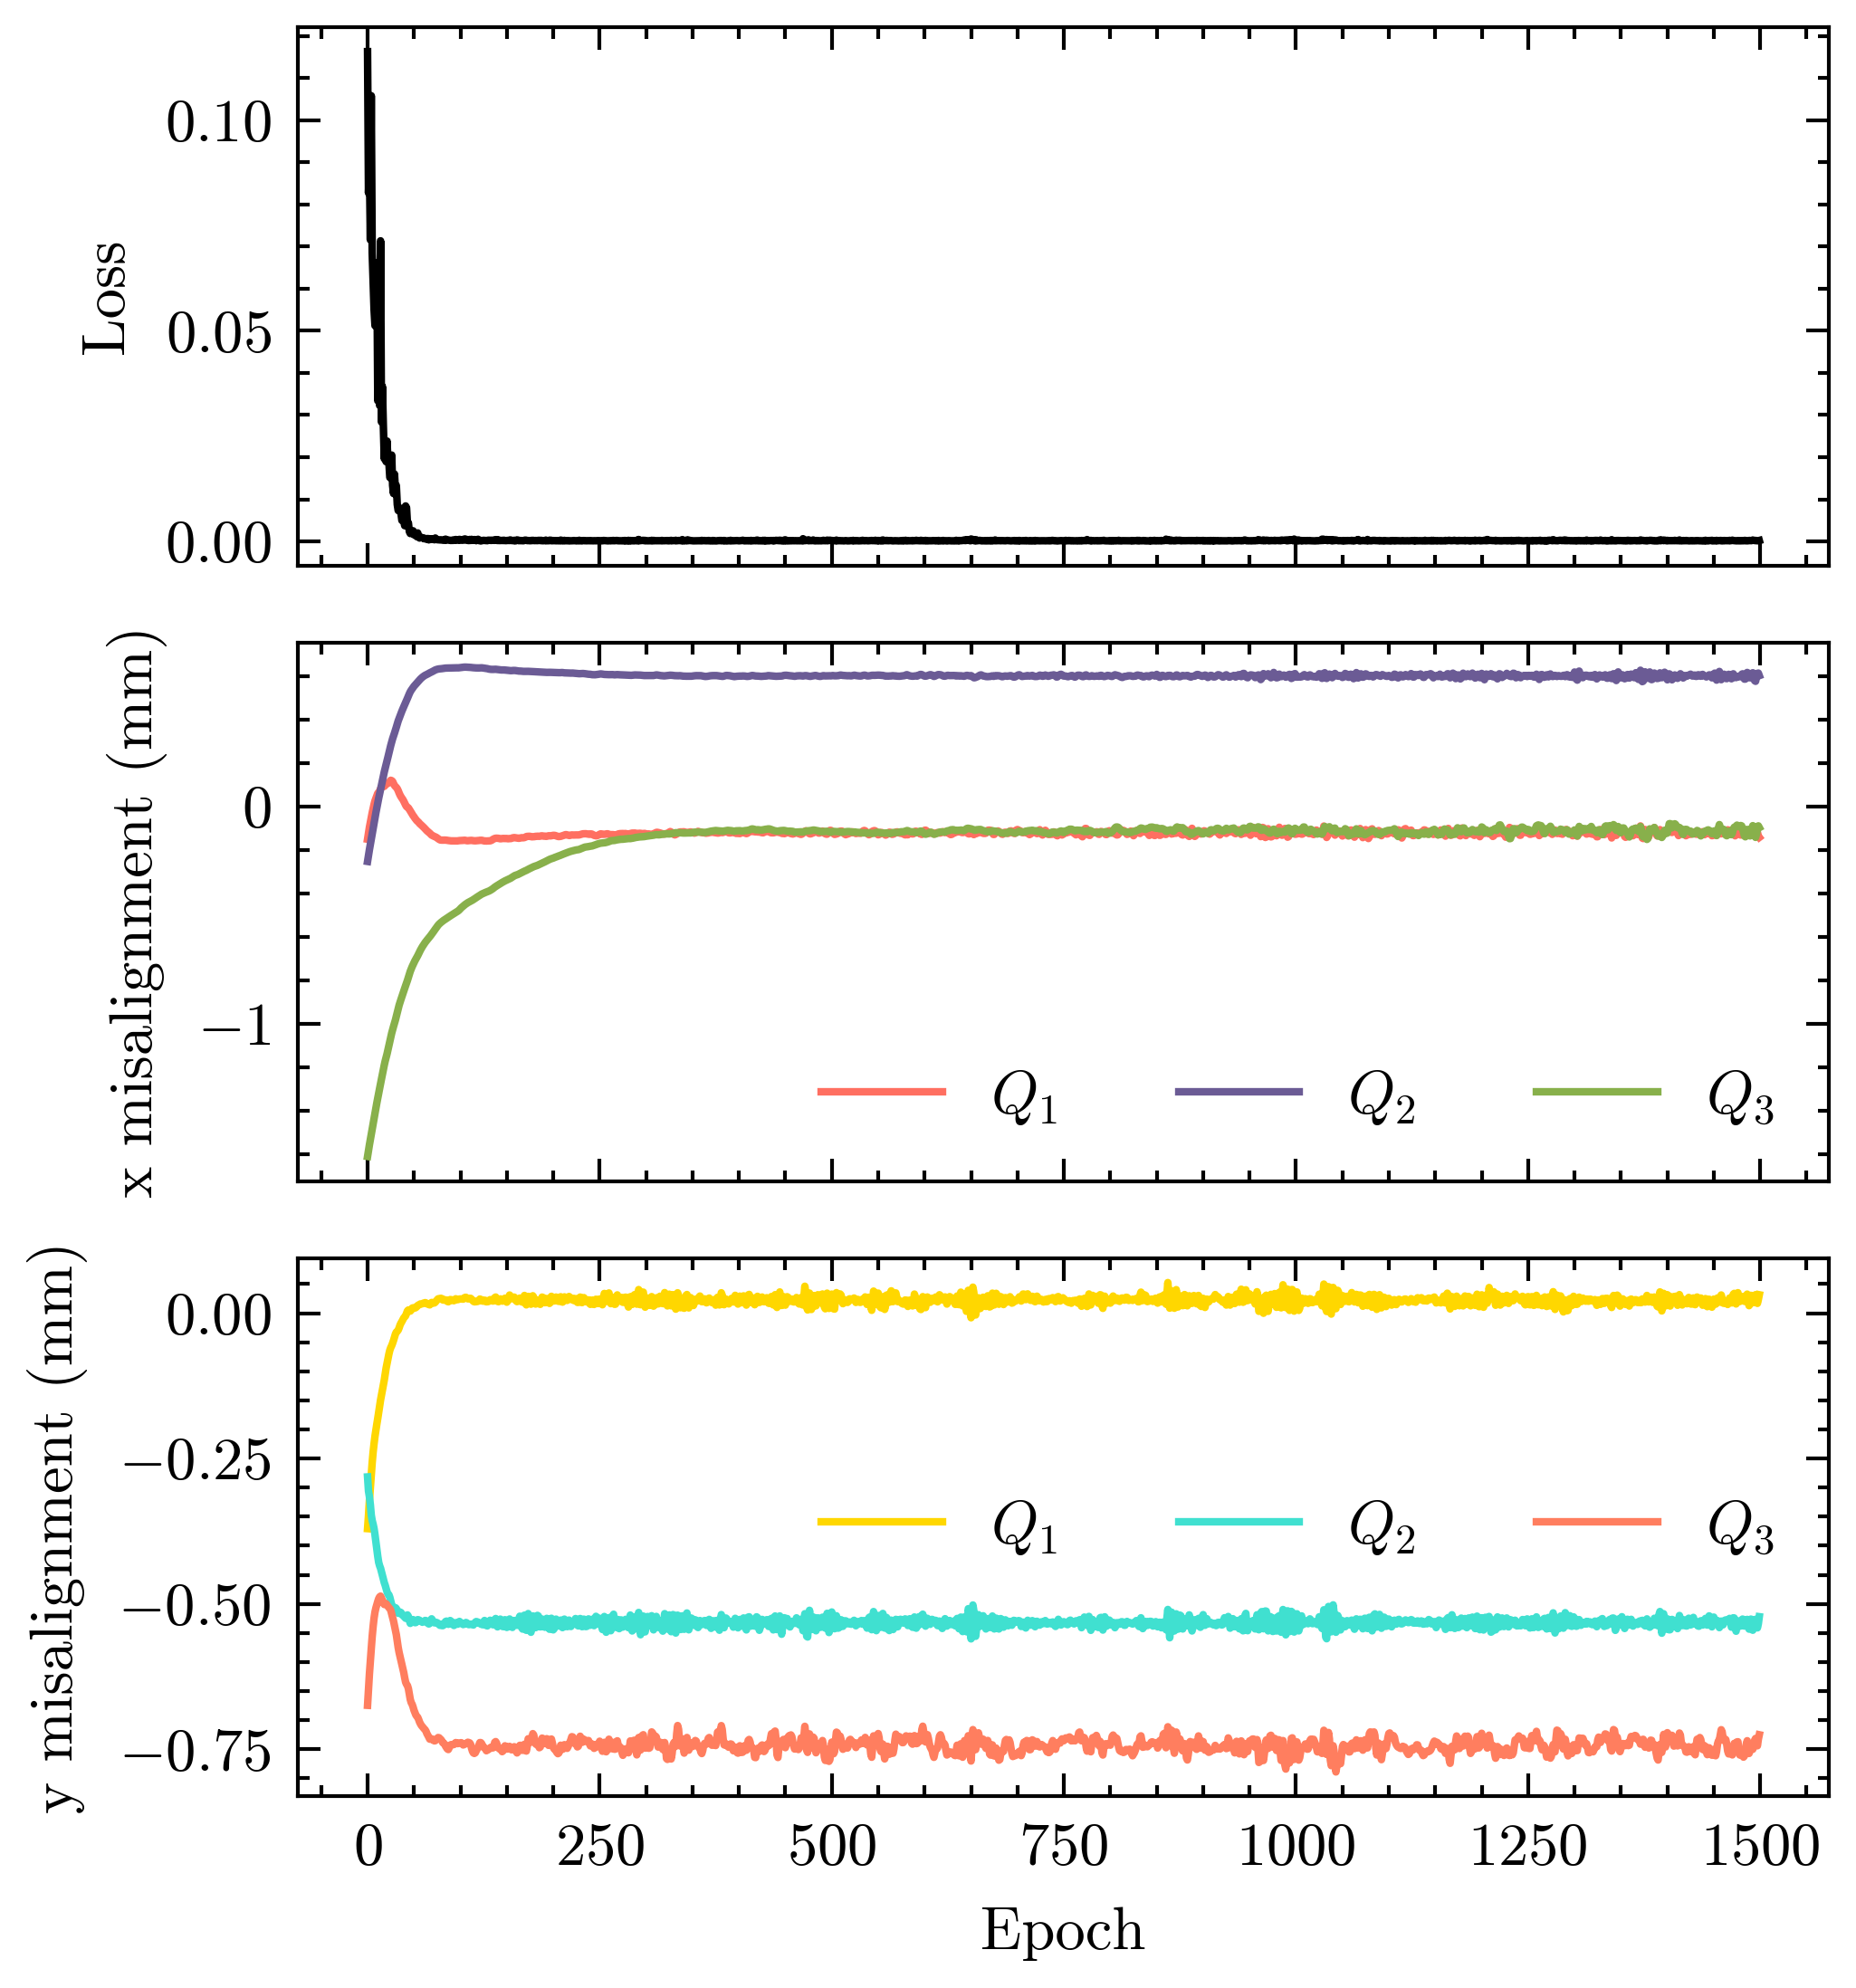

In [12]:
plot_training(history_1)

In [13]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_2 = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)

100%|██████████| 1500/1500 [00:51<00:00, 29.01it/s]


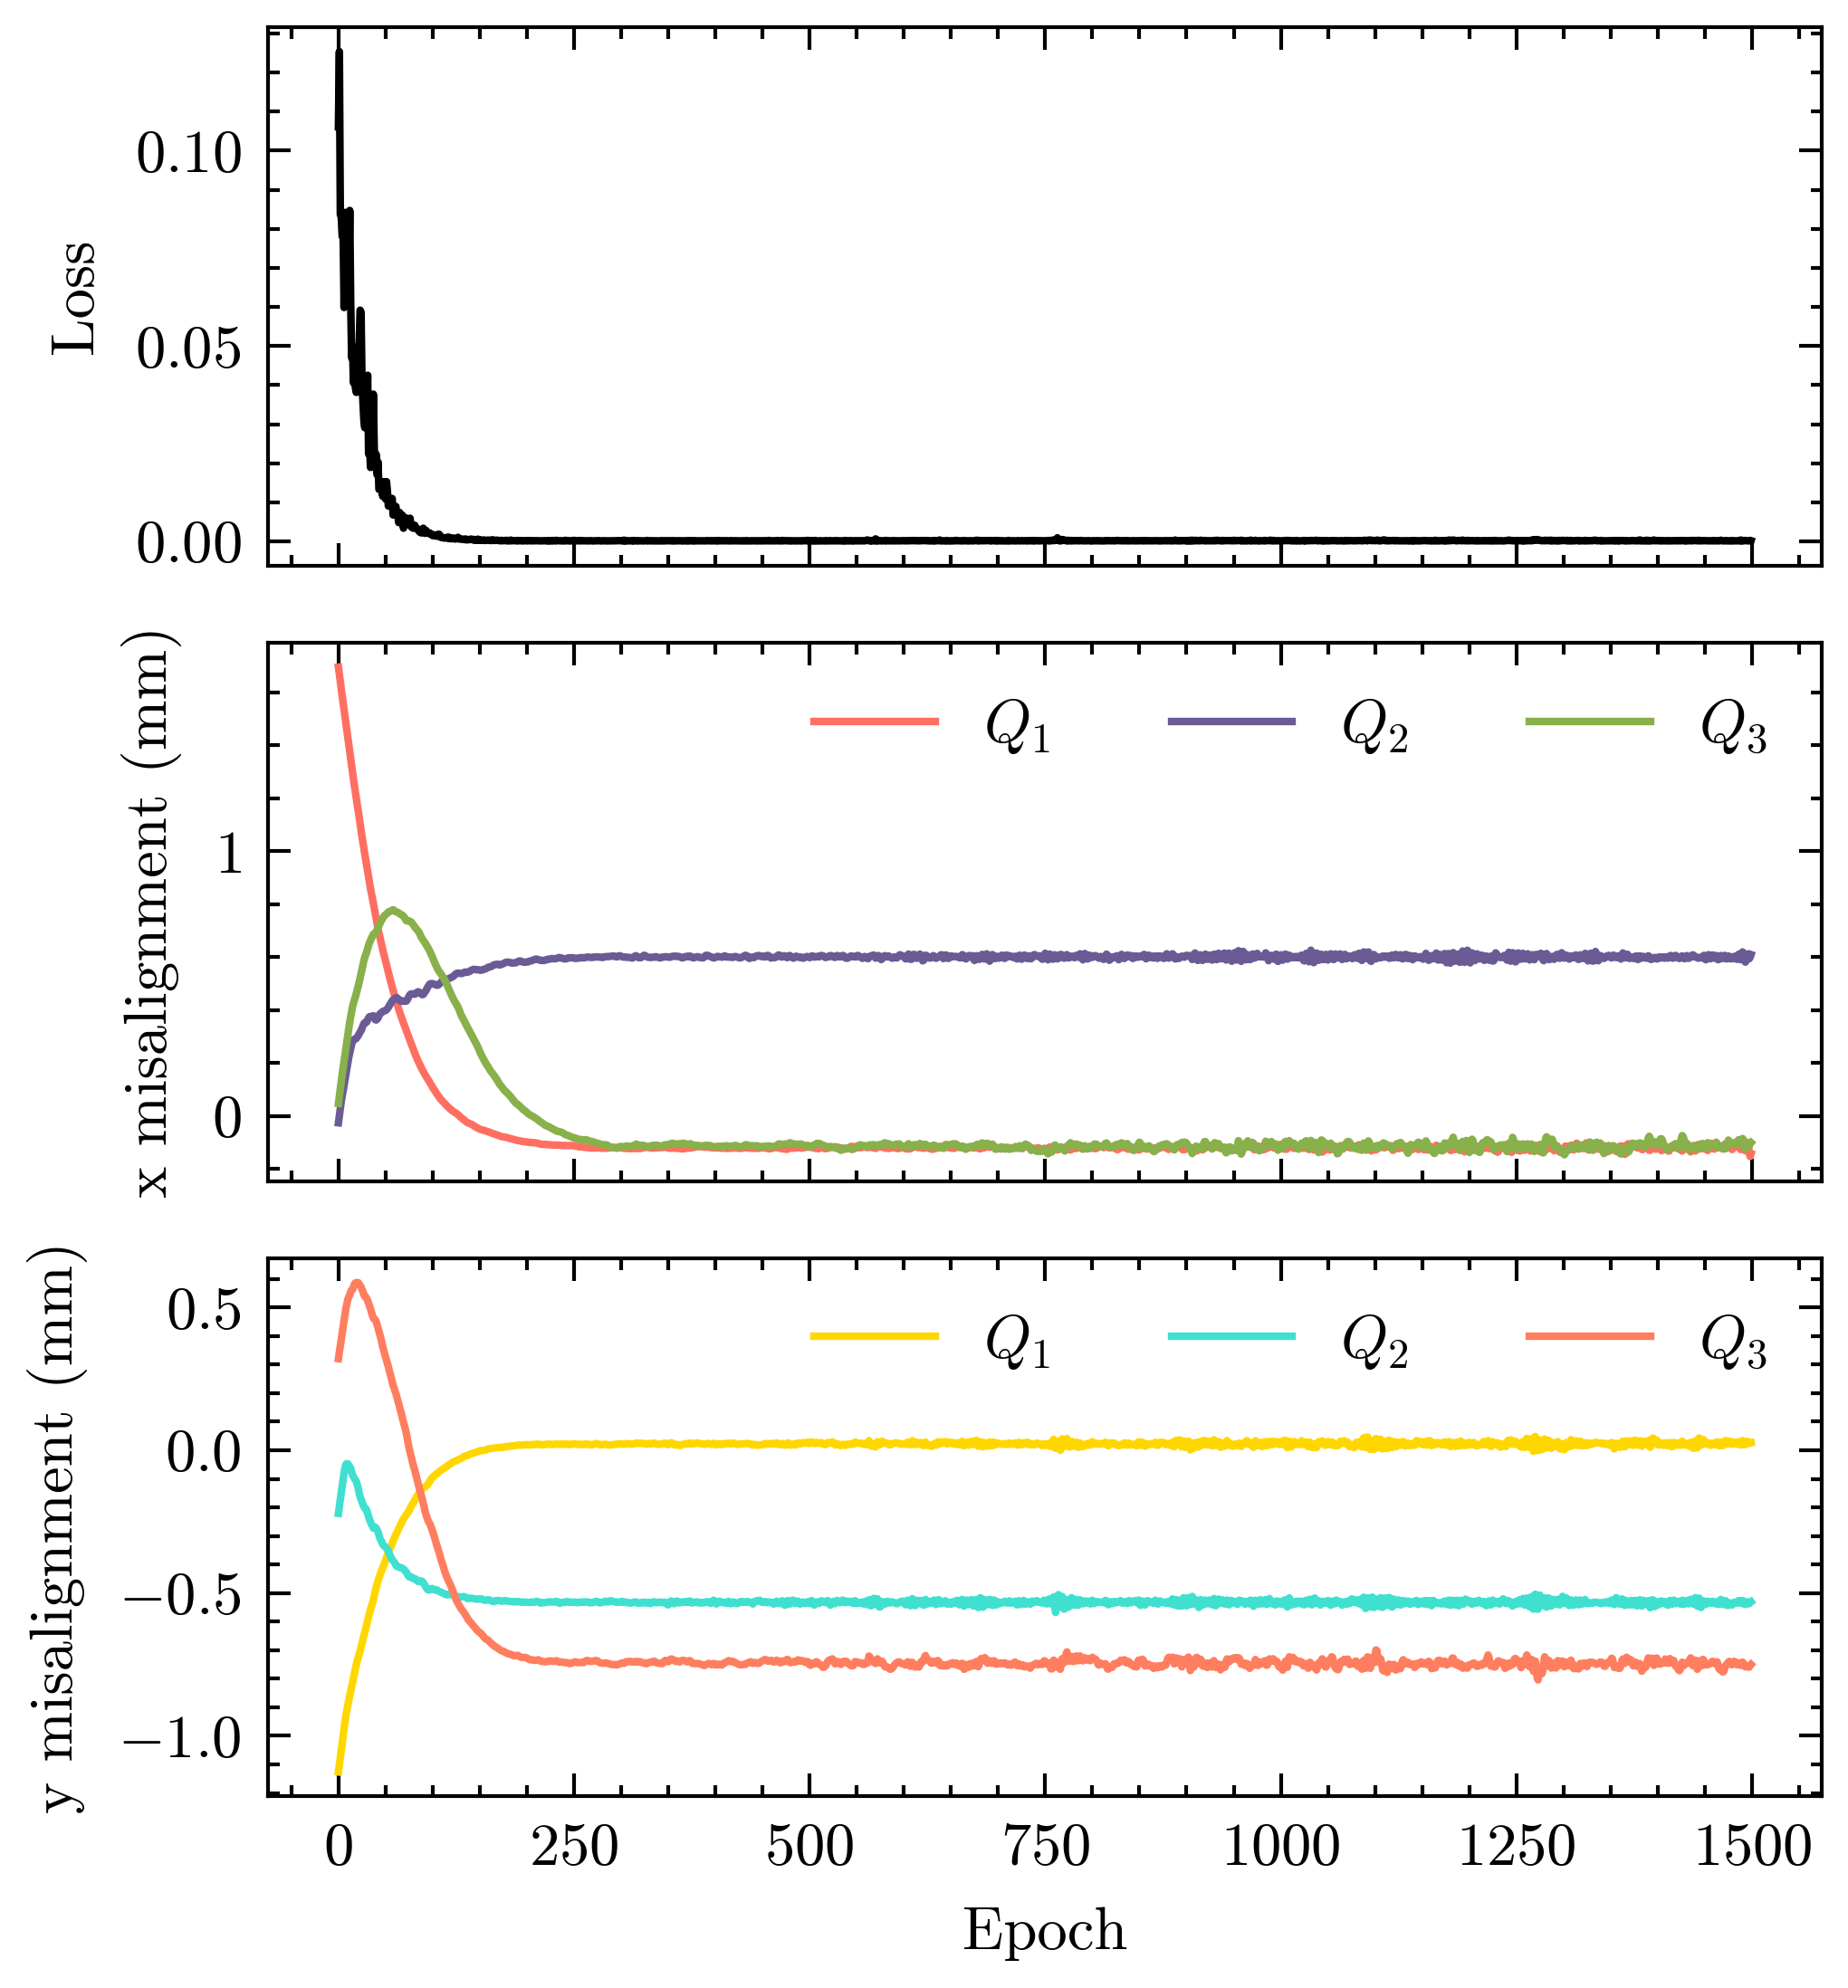

In [14]:
plot_training(history_2)

In [15]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="rl_sim_data")
history_3 = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)

100%|██████████| 1500/1500 [00:51<00:00, 28.91it/s]


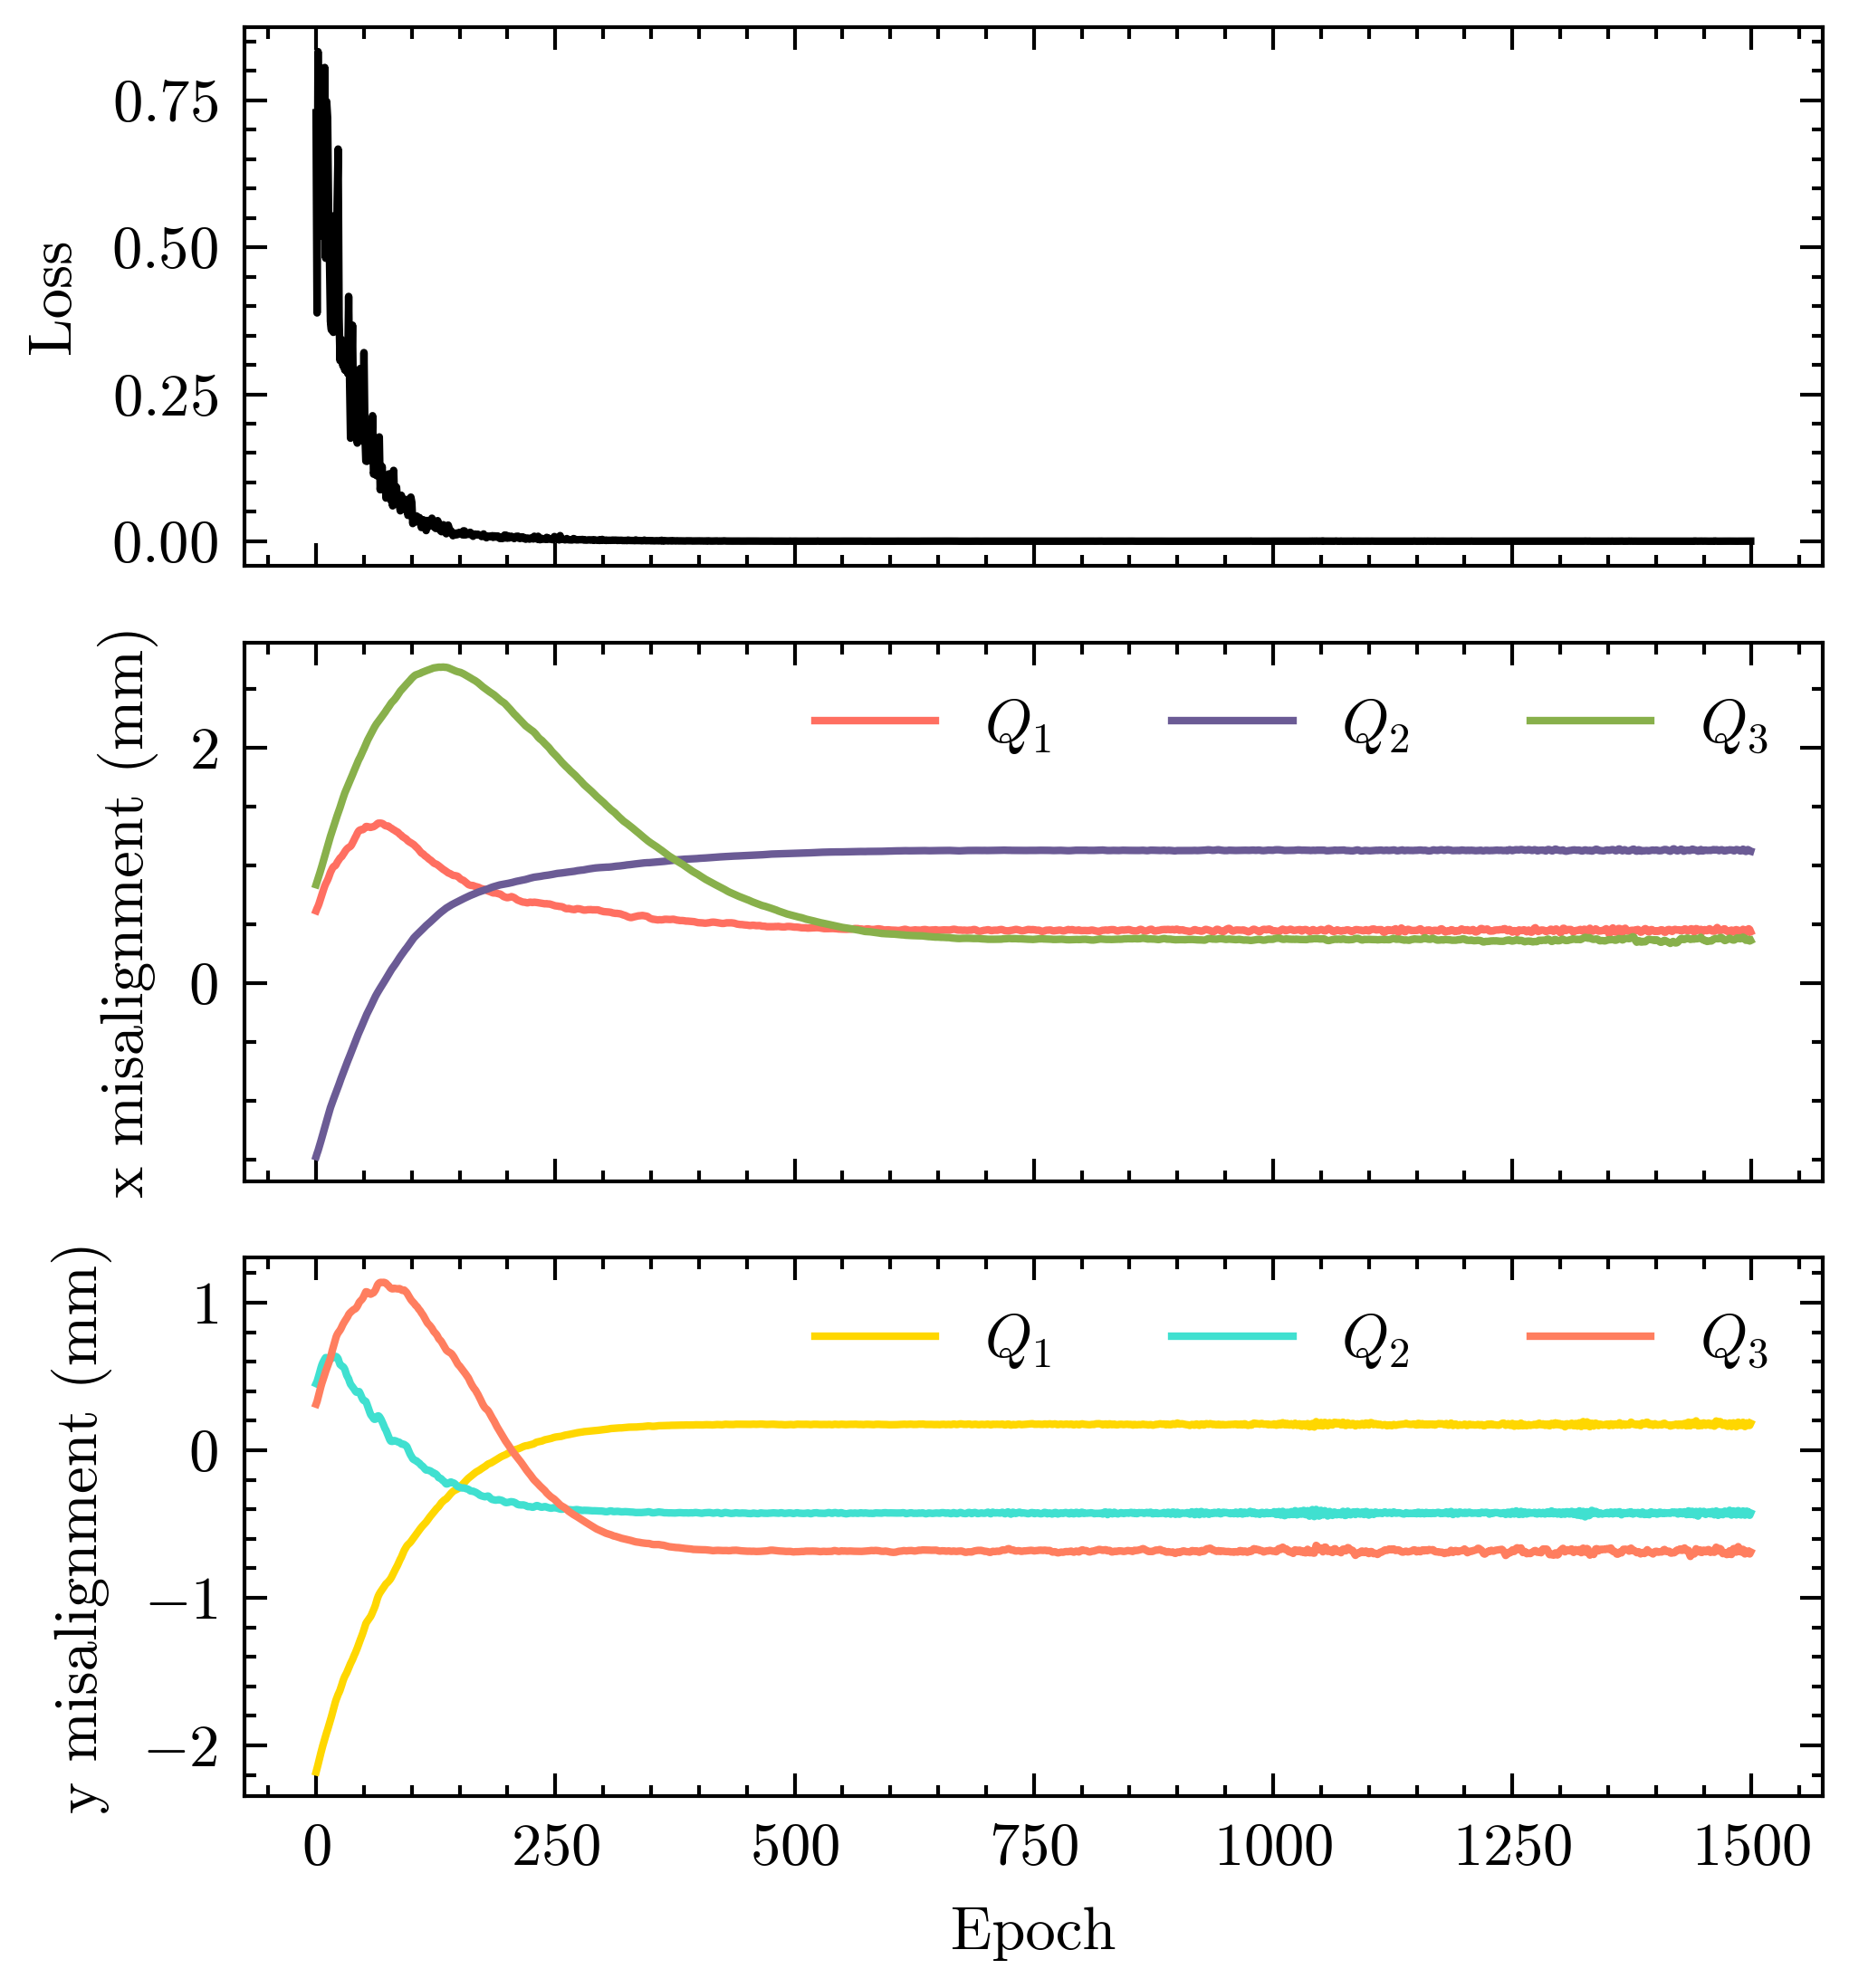

In [16]:
plot_training(history_3)

In [17]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_rl_sim_data")
history_4 = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)

100%|██████████| 1500/1500 [00:51<00:00, 29.28it/s]


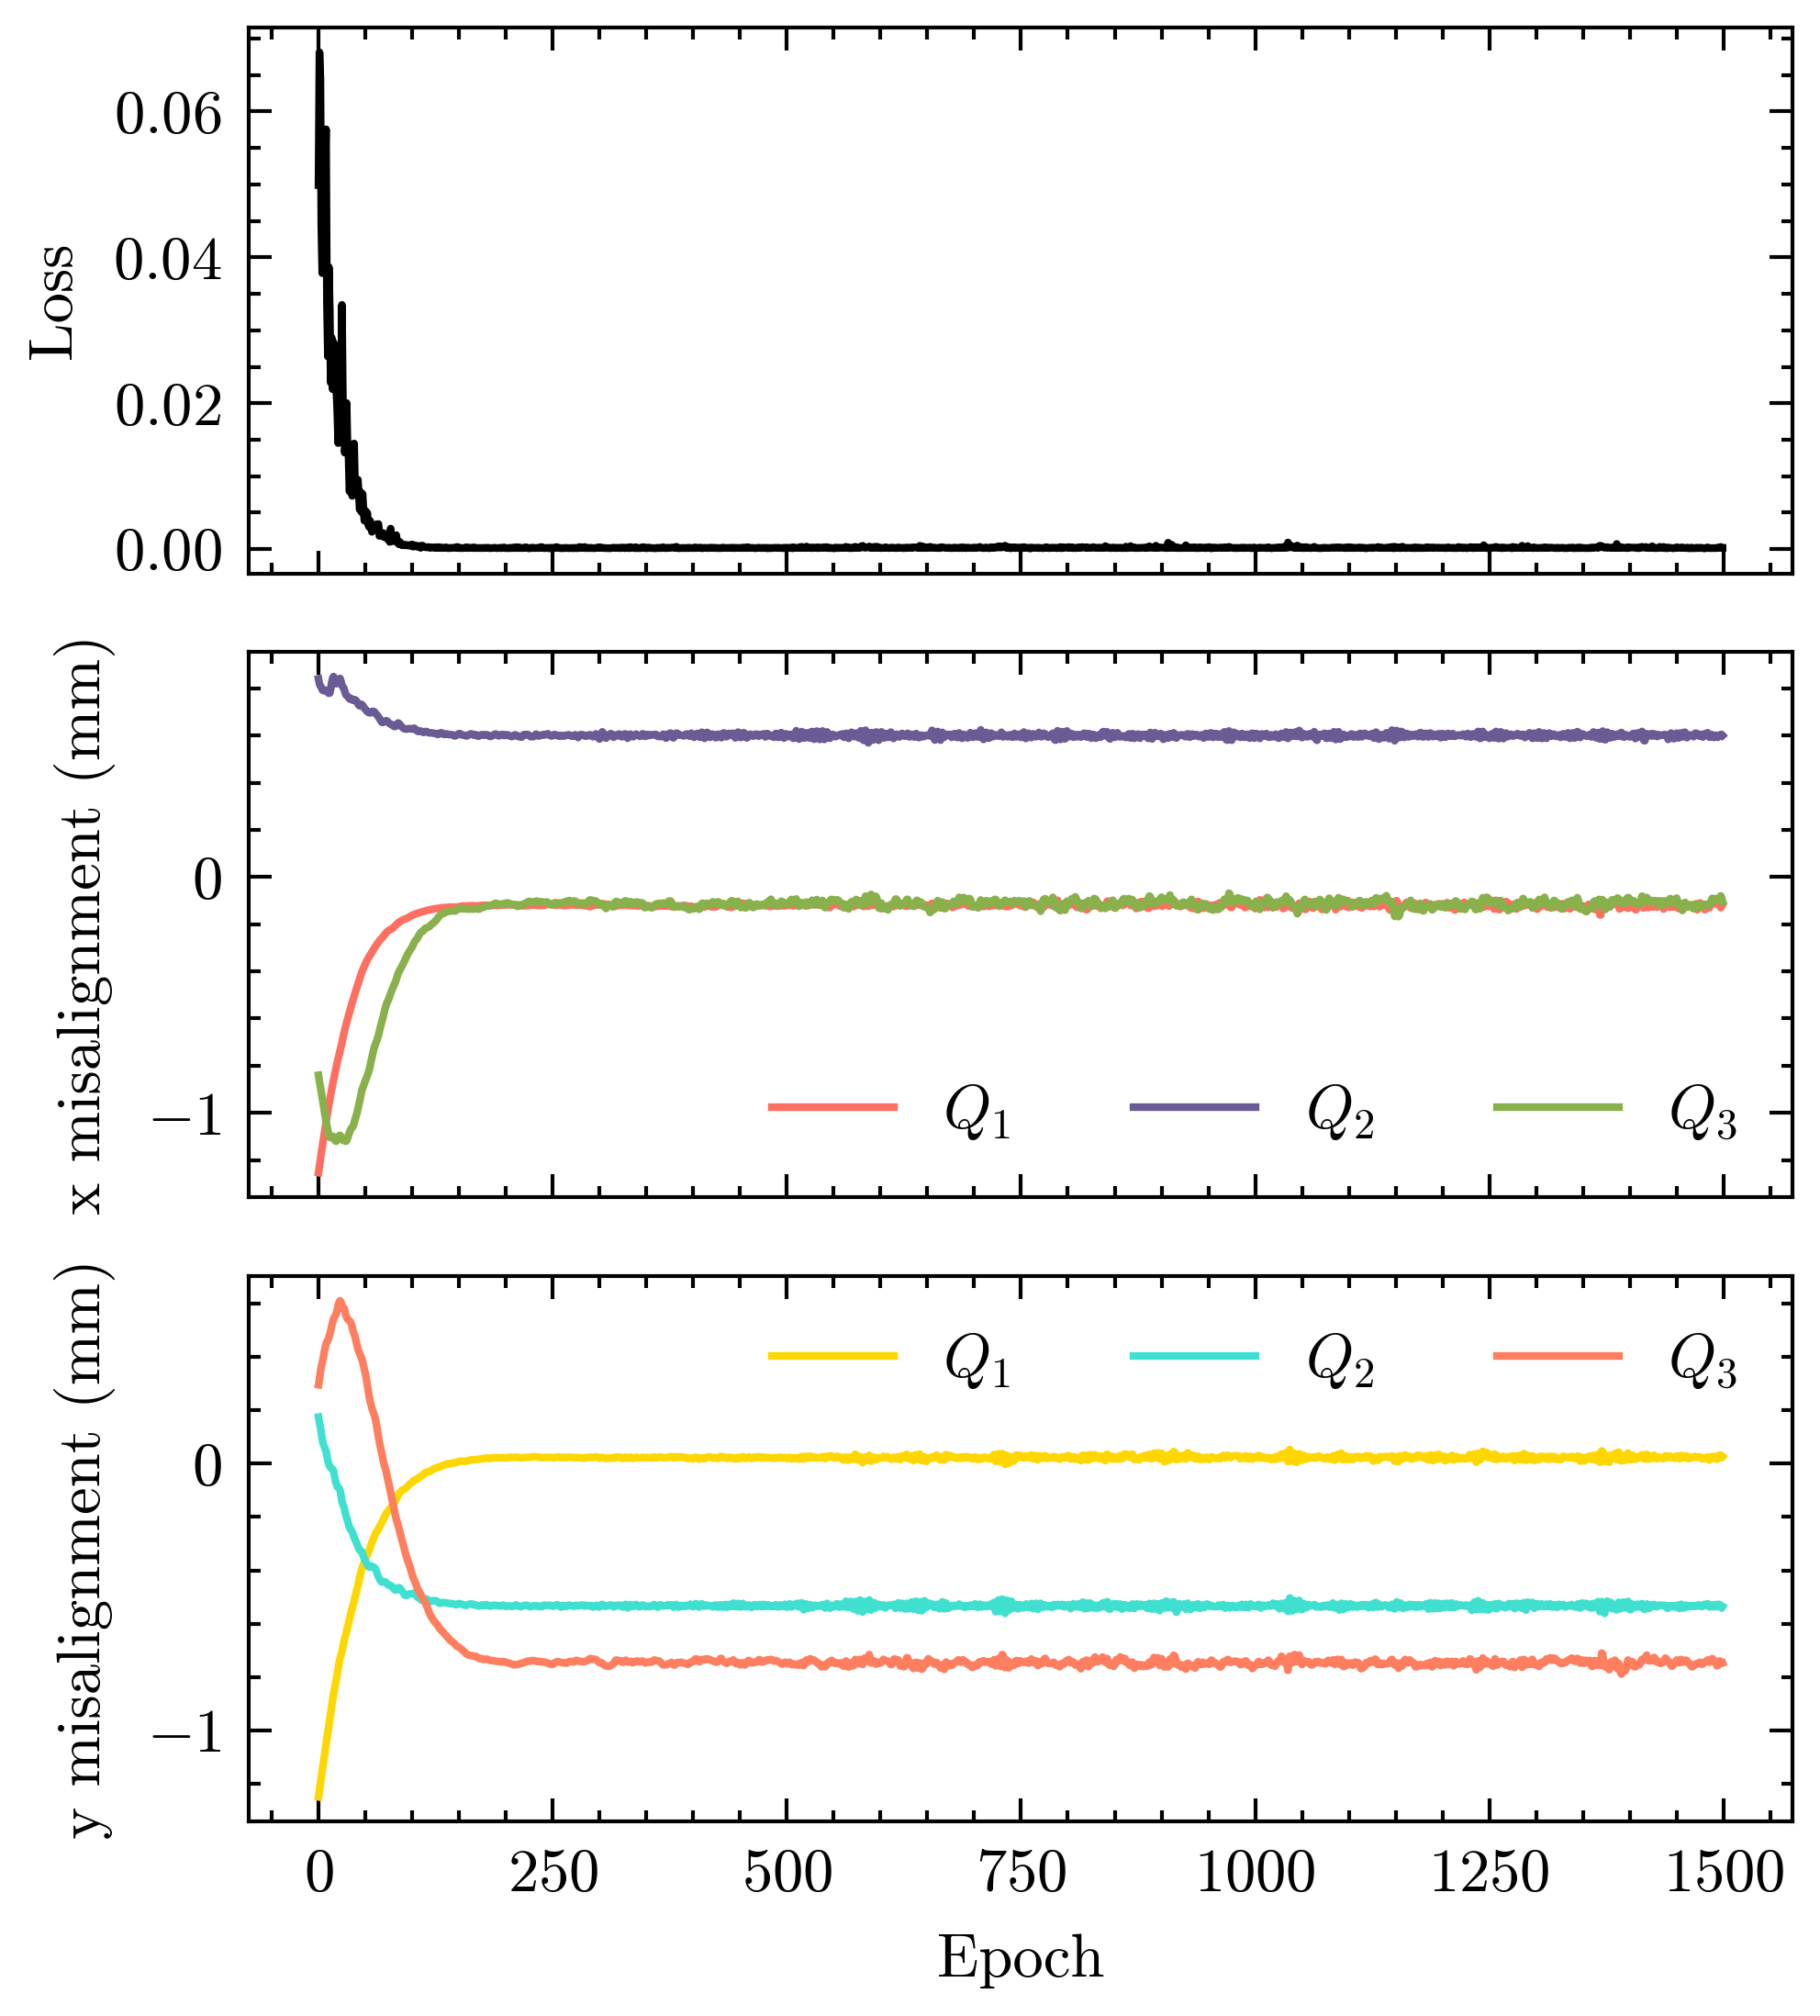

In [18]:
plot_training(history_4)

In [19]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_5 = train_normalized(model=normalized_ares_ea, num_epochs=1_000, data=bo_data)

100%|██████████| 1000/1000 [00:45<00:00, 21.79it/s]


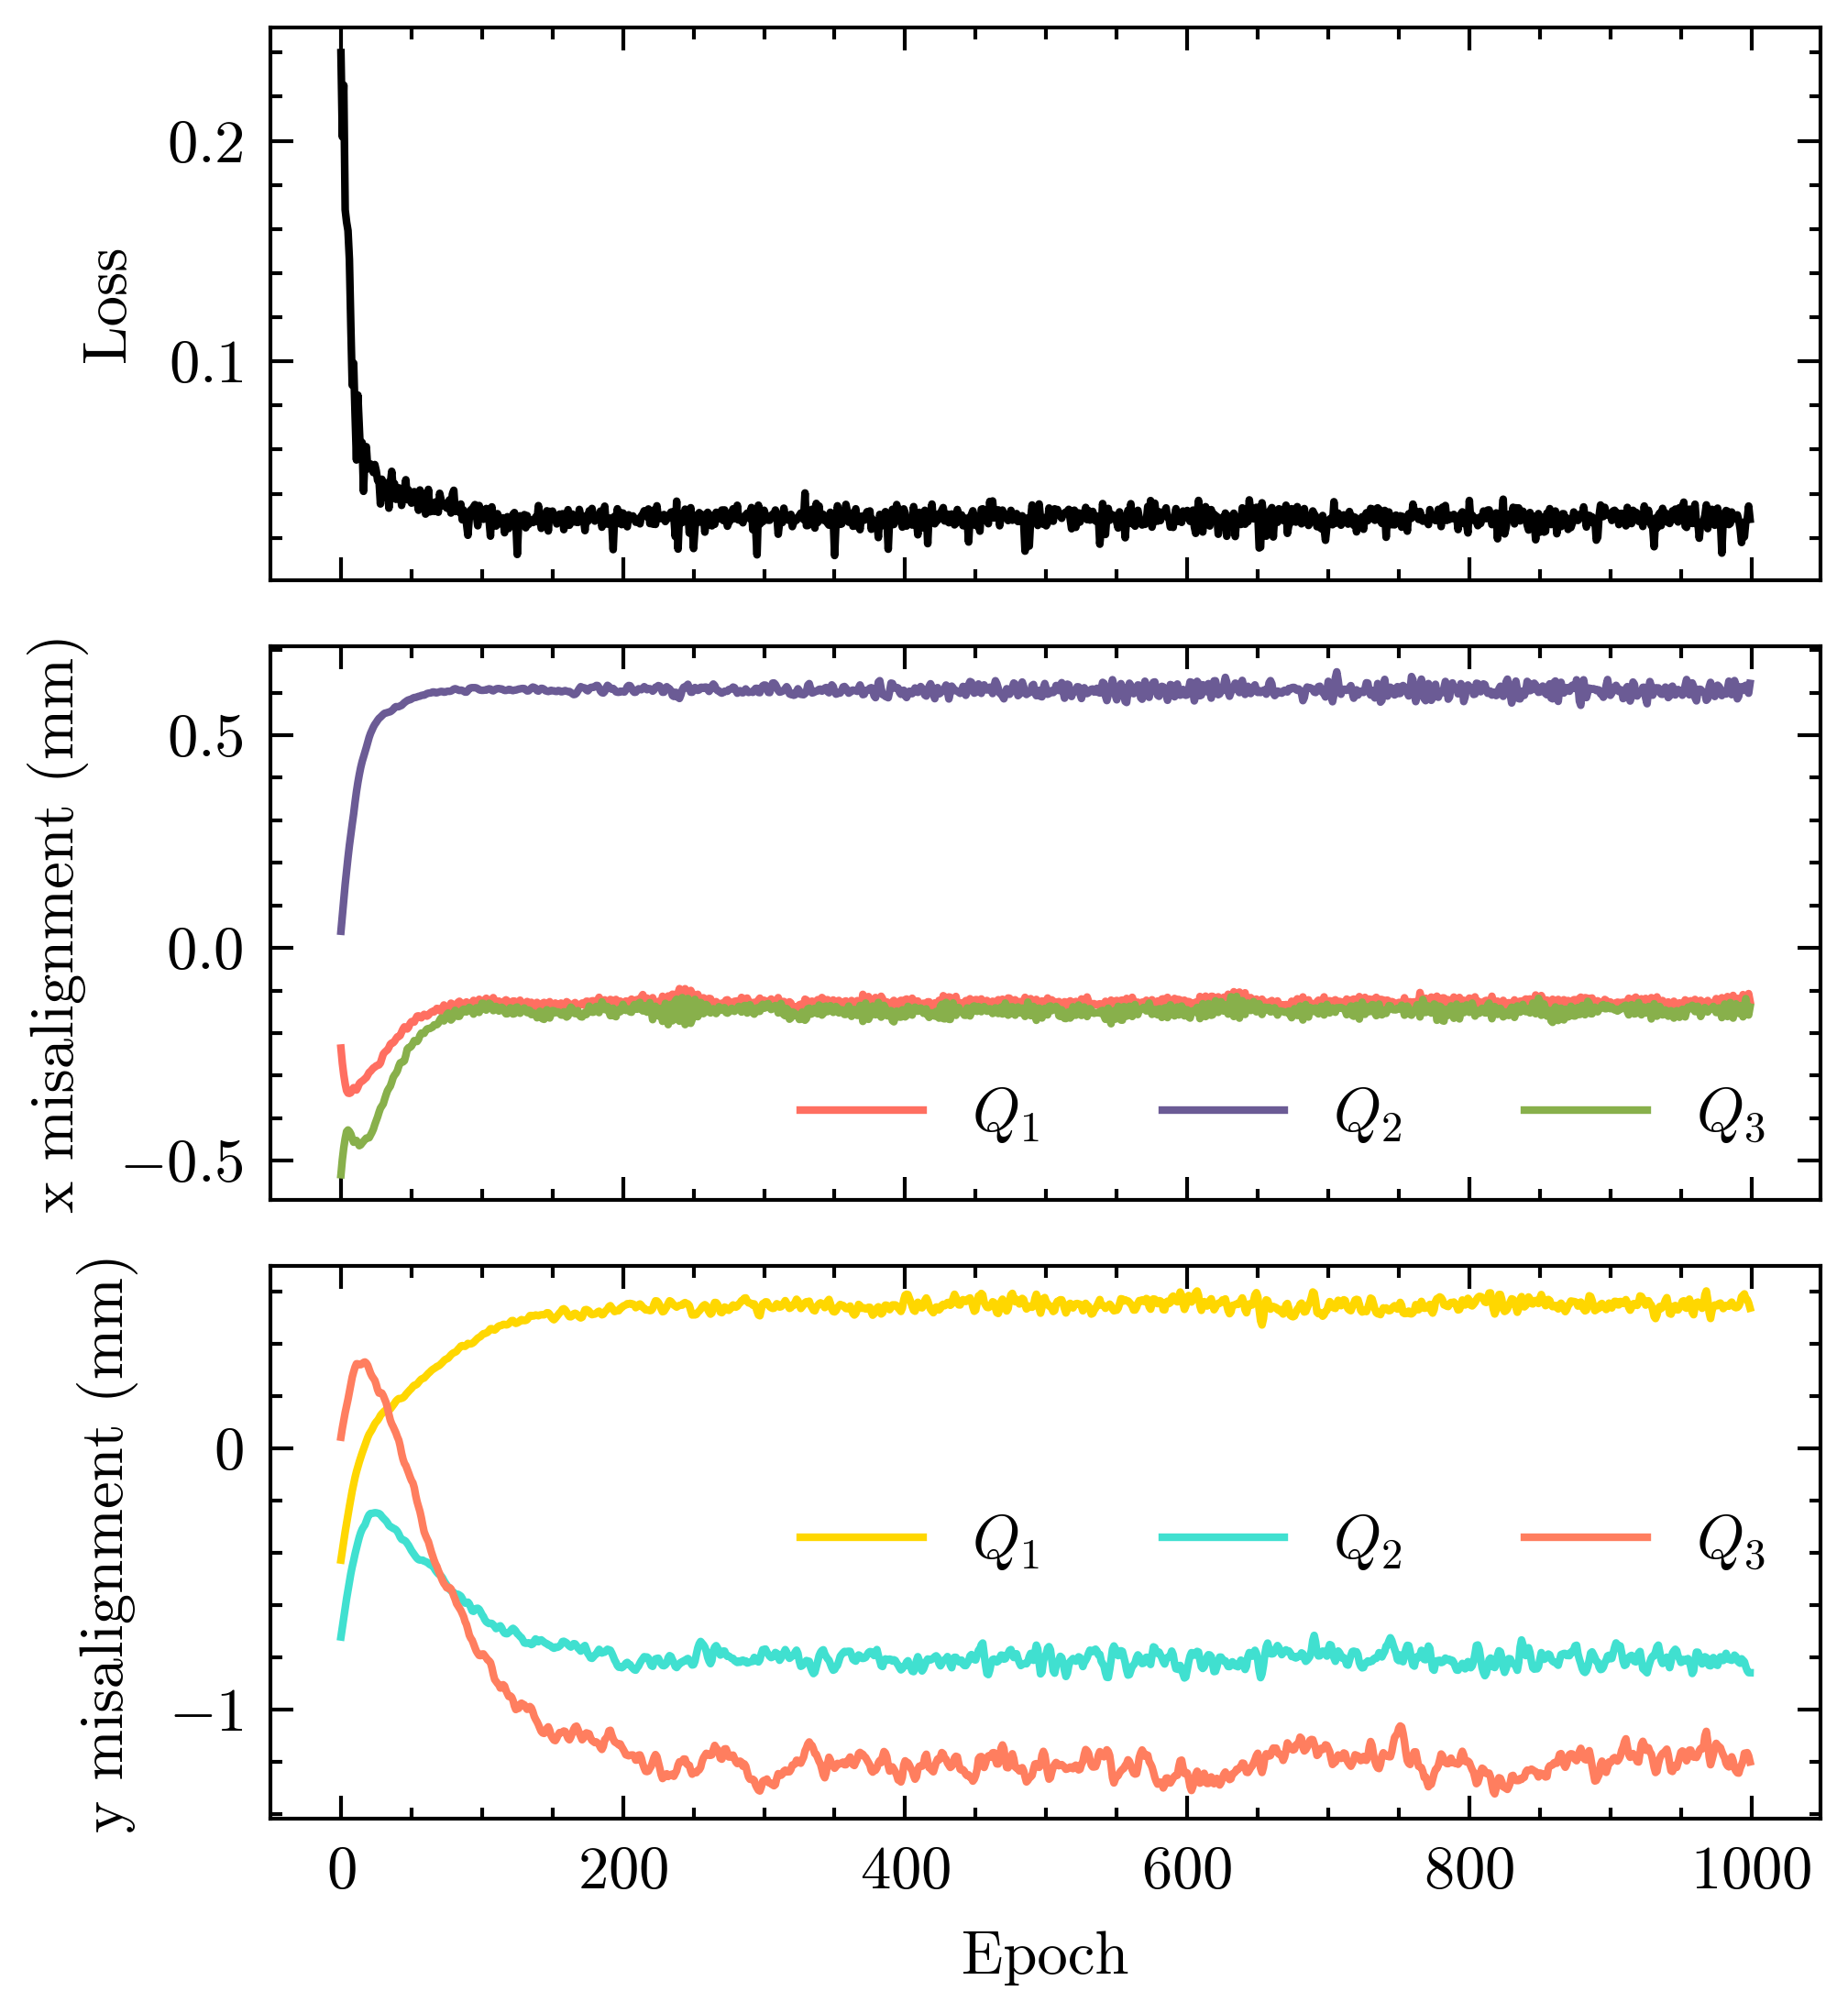

In [20]:
plot_training(history_5)

In [21]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_6 = train_normalized(
    model=normalized_ares_ea, num_epochs=600, data=real_combined
)

100%|██████████| 600/600 [00:44<00:00, 13.50it/s]


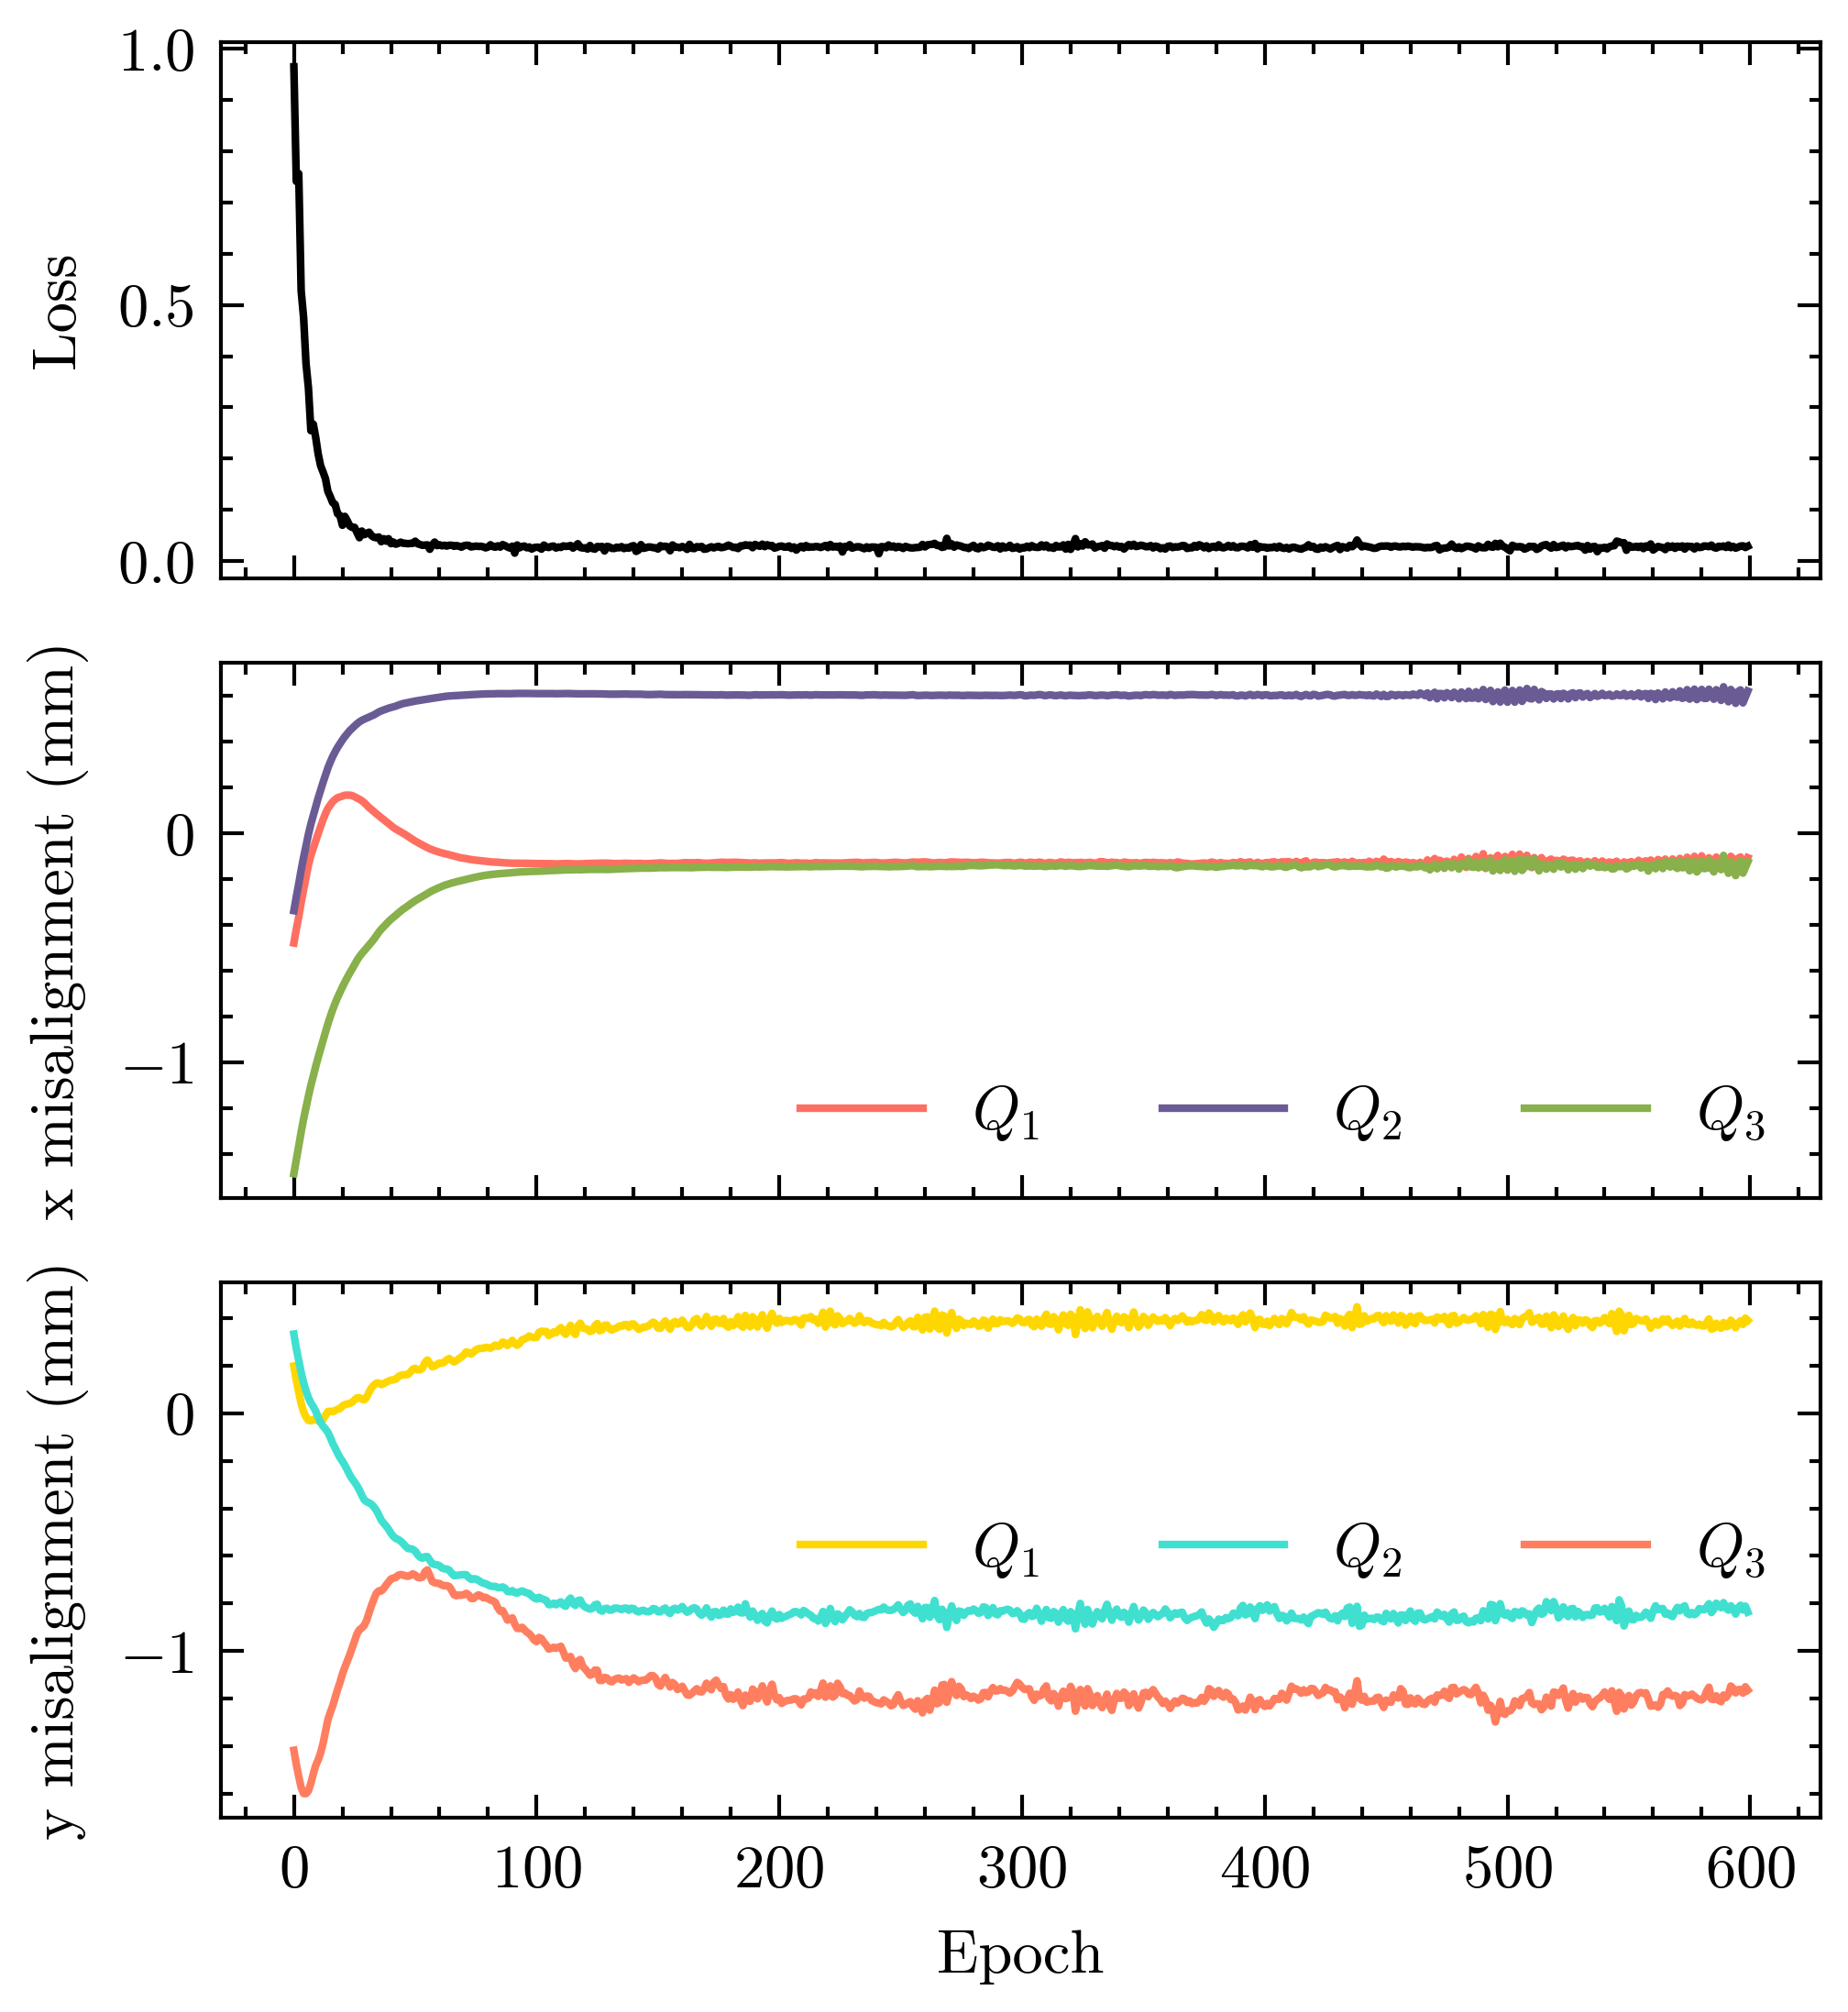

In [22]:
plot_training(history_6)

In [23]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="rl_sim_data")
history_7 = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)

100%|██████████| 500/500 [00:45<00:00, 10.94it/s]


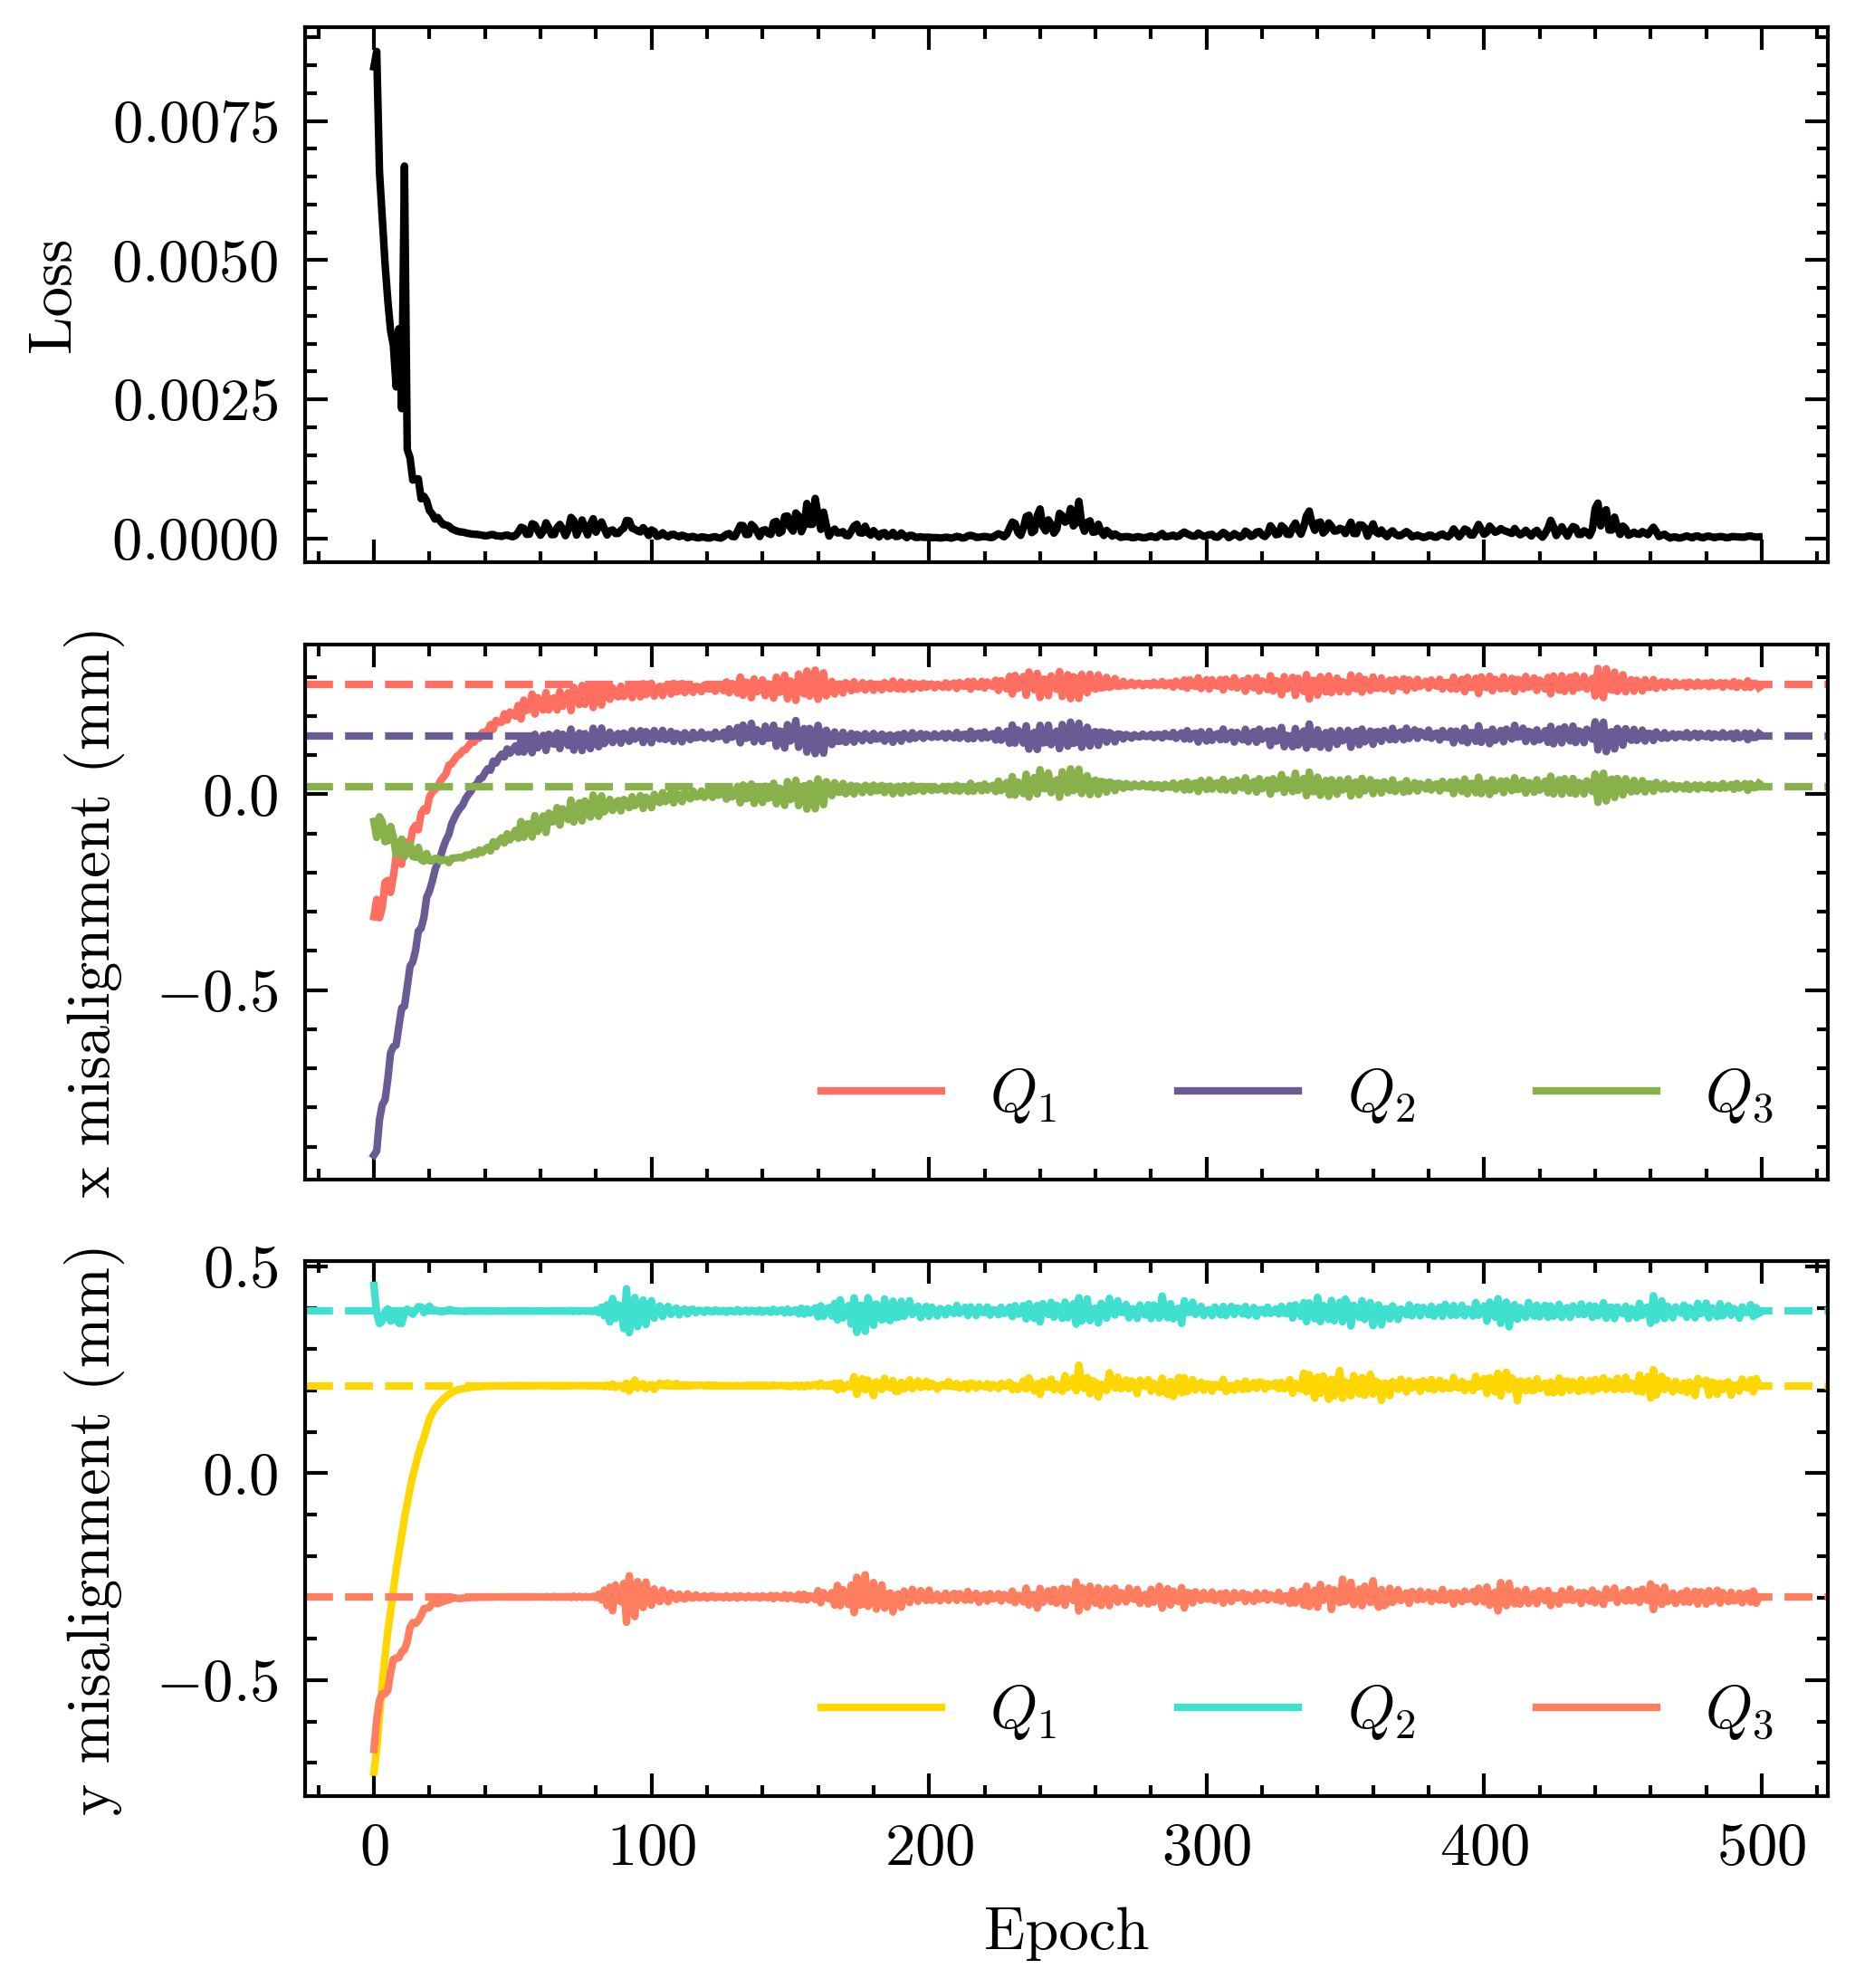

In [24]:
plot_training(history_7, ground_truth=rl_data_sim["observations"][0]["misalignments"])

In [25]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history_8 = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)

100%|██████████| 500/500 [00:44<00:00, 11.11it/s]


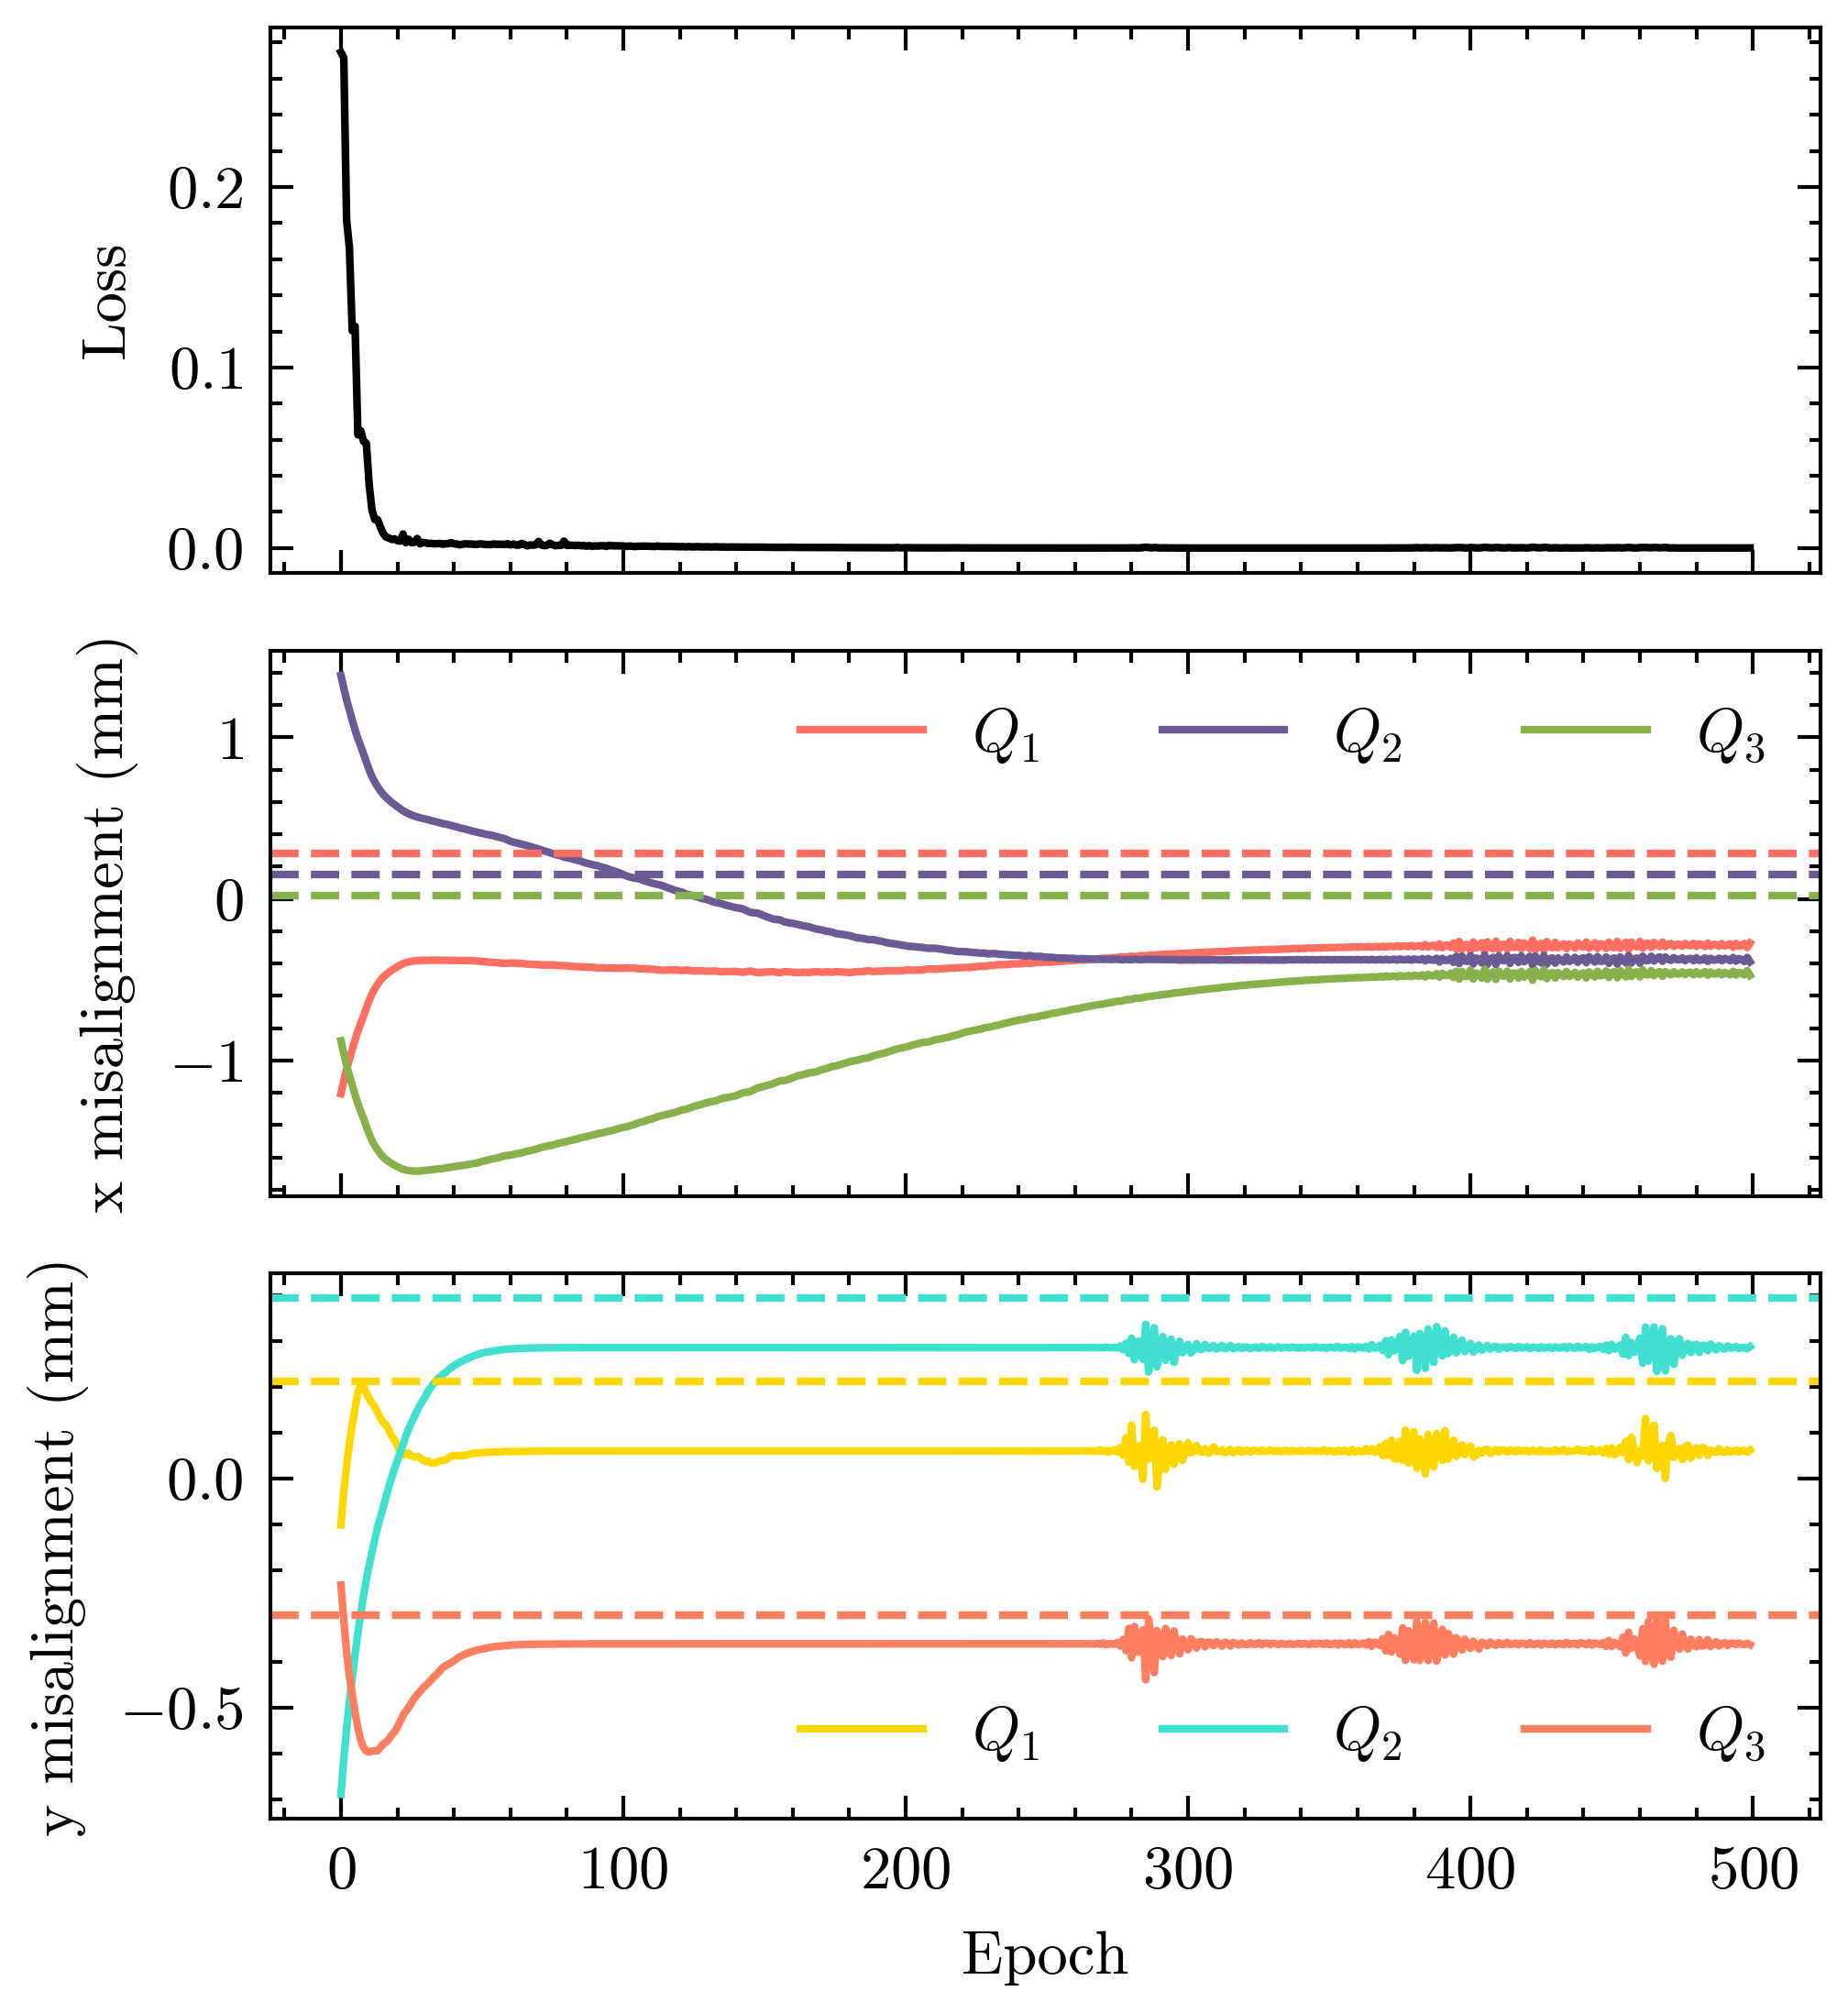

In [26]:
plot_training(history_8, ground_truth=rl_data_sim["observations"][0]["misalignments"])

In [27]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_rl_sim_data")
history_9 = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)

100%|██████████| 500/500 [00:46<00:00, 10.87it/s]


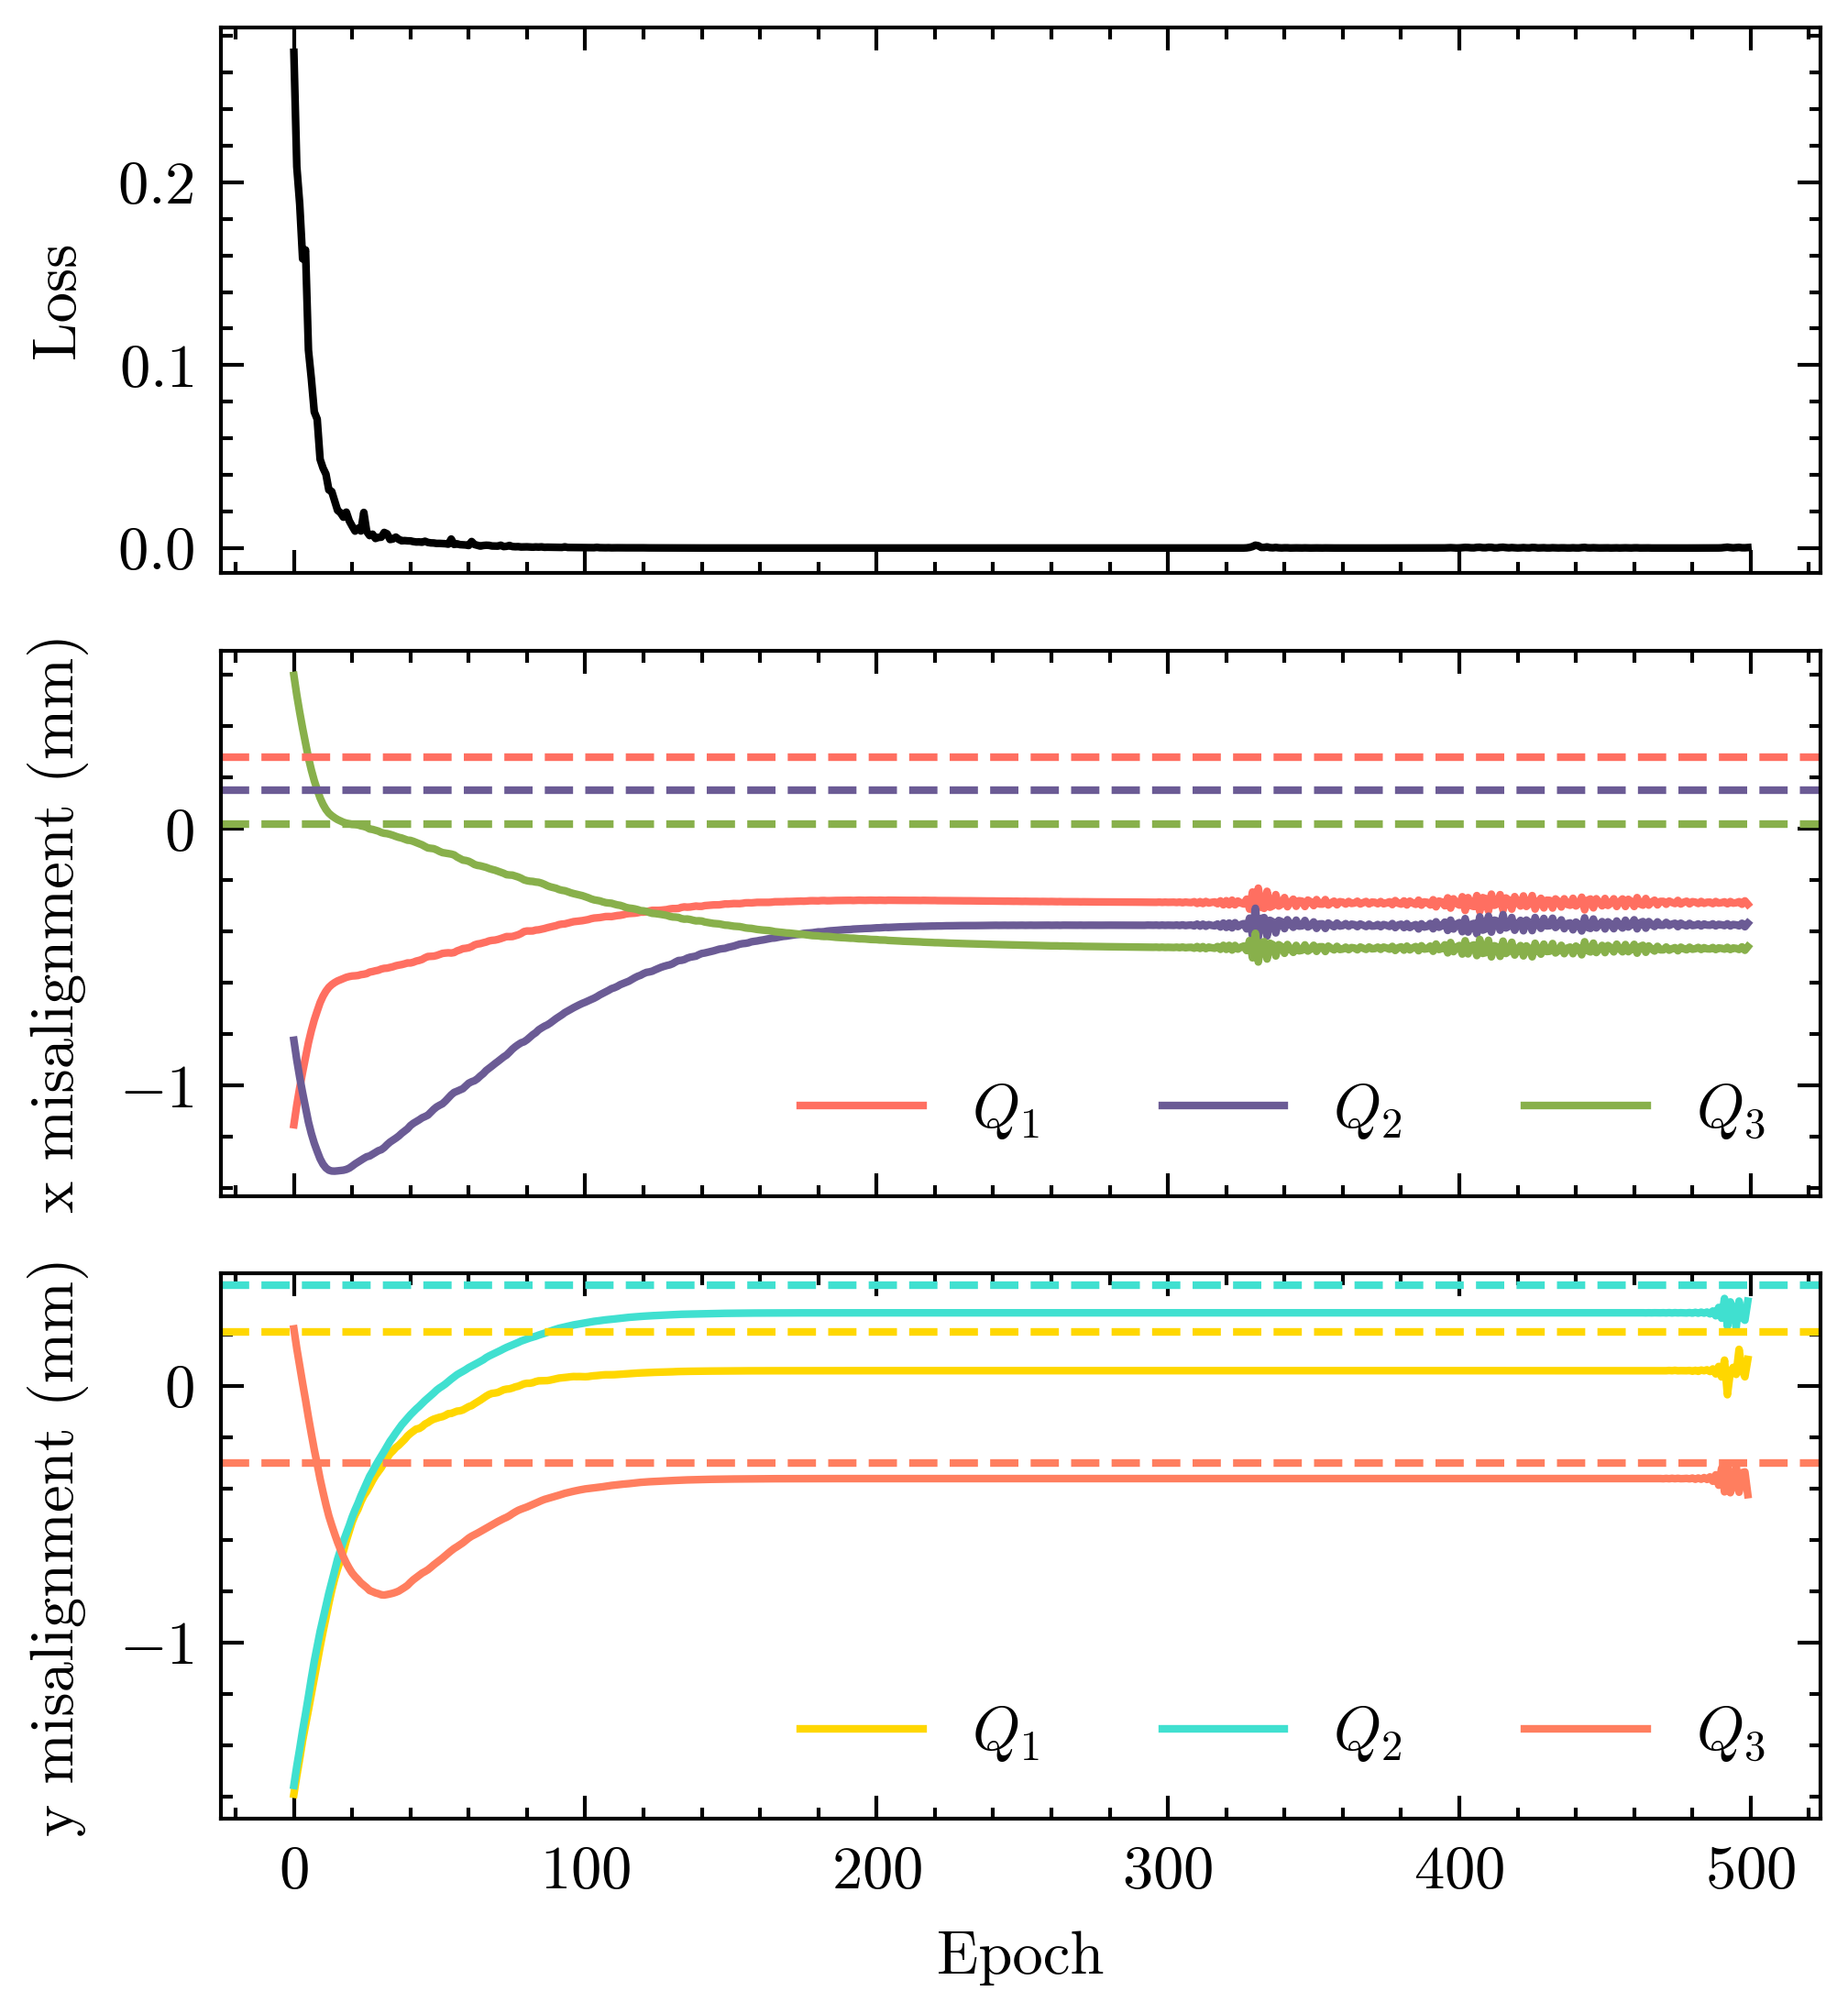

In [28]:
plot_training(history_9, ground_truth=rl_data_sim["observations"][0]["misalignments"])

In [29]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="uncentered_astra")
history_10 = train_normalized(
    model=normalized_ares_ea, num_epochs=500, data=rl_data_sim
)

100%|██████████| 500/500 [00:45<00:00, 10.95it/s]


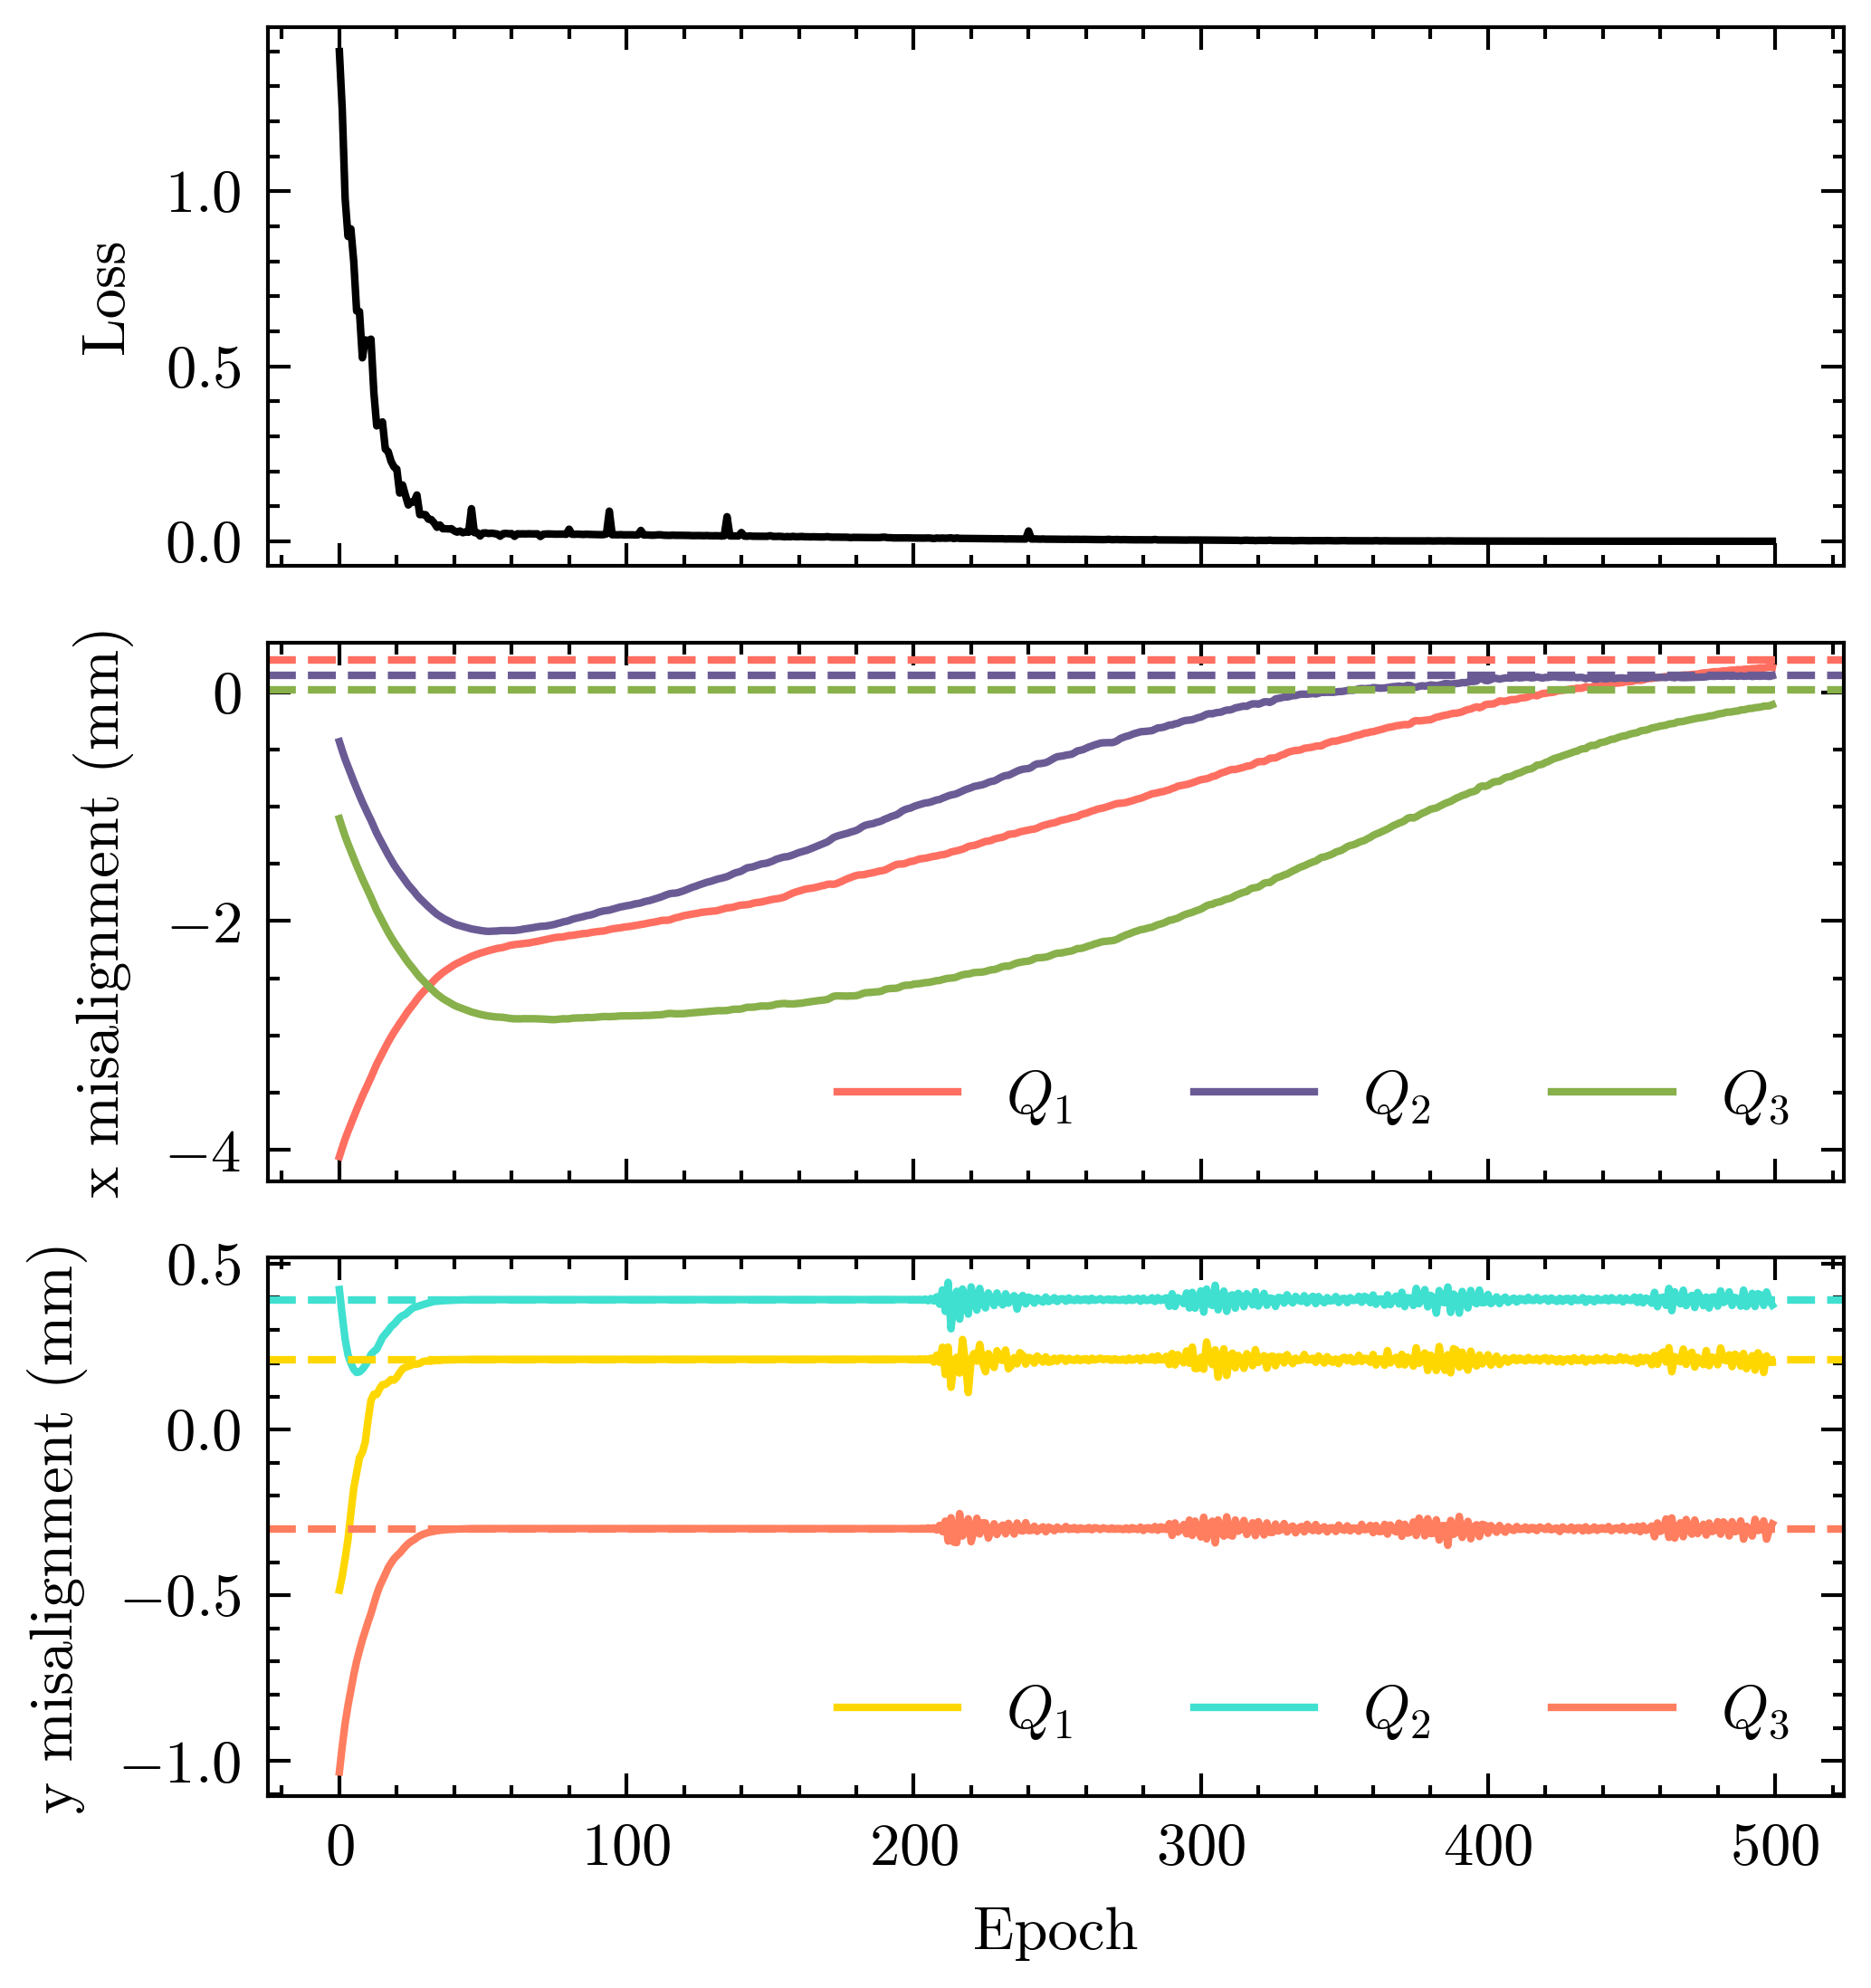

In [30]:
plot_training(history_10, ground_truth=rl_data_sim["observations"][0]["misalignments"])

In [31]:
# Make combined simulation and real-world plot for paper
def plot_two_trainings(
    history_a: dict,
    history_b: dict,
    ground_truth_a: Optional[np.ndarray] = None,
    ground_truth_b: Optional[np.ndarray] = None,
    title_a: Optional[str] = None,
    title_b: Optional[str] = None,
    save_path: Optional[str] = None,
) -> None:
    fig, axs = plt.subplots(
        3, 2, figsize=(7.16 - 4.6 / 72.72, 3.8), sharex="col", sharey="row"
    )

    axs[0, 0].plot(history_a["loss"])
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_title(title_a)
    axs[0, 0].text(x=0.92, y=0.8, s="(a)", transform=axs[0, 0].transAxes)

    axs[1, 0].plot(
        [record[0] * 1e3 for record in history_a["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FFD700",
    )
    axs[1, 0].plot(
        [record[0] * 1e3 for record in history_a["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#40E0D0",
    )
    axs[1, 0].plot(
        [record[0] * 1e3 for record in history_a["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#FF7E5F",
    )
    if ground_truth_a is not None:
        axs[1, 0].axhline(
            ground_truth_a[0] * 1e3, color="tab:blue", linestyle="--", c="#FFD700"
        )
        axs[1, 0].axhline(
            ground_truth_a[2] * 1e3, color="tab:orange", linestyle="--", c="#40E0D0"
        )
        axs[1, 0].axhline(
            ground_truth_a[4] * 1e3, color="tab:green", linestyle="--", c="#FF7E5F"
        )
    axs[1, 0].set_ylabel("x misalignment (mm)")
    # axs[1, 0].legend(ncol=3)
    axs[1, 0].text(x=0.92, y=0.8, s="(c)", transform=axs[1, 0].transAxes)

    axs[2, 0].plot(
        [record[1] * 1e3 for record in history_a["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FFD700",
    )
    axs[2, 0].plot(
        [record[1] * 1e3 for record in history_a["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#40E0D0",
    )
    axs[2, 0].plot(
        [record[1] * 1e3 for record in history_a["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#FF7E5F",
    )
    if ground_truth_a is not None:
        axs[2, 0].axhline(ground_truth_a[1] * 1e3, linestyle="--", c="#FFD700")
        axs[2, 0].axhline(ground_truth_a[3] * 1e3, linestyle="--", c="#40E0D0")
        axs[2, 0].axhline(ground_truth_a[5] * 1e3, linestyle="--", c="#FF7E5F")
    axs[2, 0].set_xlabel("Epoch")
    axs[2, 0].set_ylabel("y misalignment (mm)")
    axs[2, 0].legend(ncol=3)
    axs[2, 0].text(x=0.92, y=0.61, s="(e)", transform=axs[2, 0].transAxes)

    # ----------------

    axs[0, 1].plot(history_b["loss"])
    axs[0, 1].set_title(title_b)
    axs[0, 1].text(x=0.92, y=0.8, s="(b)", transform=axs[0, 1].transAxes)

    axs[1, 1].plot(
        [record[0] * 1e3 for record in history_b["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FFD700",
    )
    axs[1, 1].plot(
        [record[0] * 1e3 for record in history_b["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#40E0D0",
    )
    axs[1, 1].plot(
        [record[0] * 1e3 for record in history_b["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#FF7E5F",
    )
    if ground_truth_b is not None:
        axs[1, 1].axhline(
            ground_truth_b[0] * 1e3, color="tab:blue", linestyle="--", c="#FF6F61"
        )
        axs[1, 1].axhline(
            ground_truth_b[2] * 1e3, color="tab:orange", linestyle="--", c="#6B5B95"
        )
        axs[1, 1].axhline(
            ground_truth_b[4] * 1e3, color="tab:green", linestyle="--", c="#88B04B"
        )
    # axs[1, 1].legend(ncol=3)
    axs[1, 1].text(x=0.92, y=0.8, s="(d)", transform=axs[1, 1].transAxes)

    axs[2, 1].plot(
        [record[1] * 1e3 for record in history_b["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FFD700",
    )
    axs[2, 1].plot(
        [record[1] * 1e3 for record in history_b["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#40E0D0",
    )
    axs[2, 1].plot(
        [record[1] * 1e3 for record in history_b["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#FF7E5F",
    )
    if ground_truth_b is not None:
        axs[2, 1].axhline(
            ground_truth_b[1] * 1e3, color="tab:blue", linestyle="--", c="#FFD700"
        )
        axs[2, 1].axhline(
            ground_truth_b[3] * 1e3, color="tab:orange", linestyle="--", c="#40E0D0"
        )
        axs[2, 1].axhline(
            ground_truth_b[5] * 1e3, color="tab:green", linestyle="--", c="#FF7E5F"
        )
    axs[2, 1].set_xlabel("Epoch")
    # axs[2, 1].legend(ncol=3)
    axs[2, 1].text(x=0.92, y=0.8, s="(f)", transform=axs[2, 1].transAxes)

    # Share y axis between axs[1, 0] and axs[1, 1] and axs[2, 0] and axs[2, 1]
    # axs[1, 0].sharey(axs[1, 1])
    # axs[1, 1].set_yticklabels([])
    # axs[2, 0].sharey(axs[2, 1])
    # axs[2, 1].set_yticklabels([])

    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path)

    plt.show()

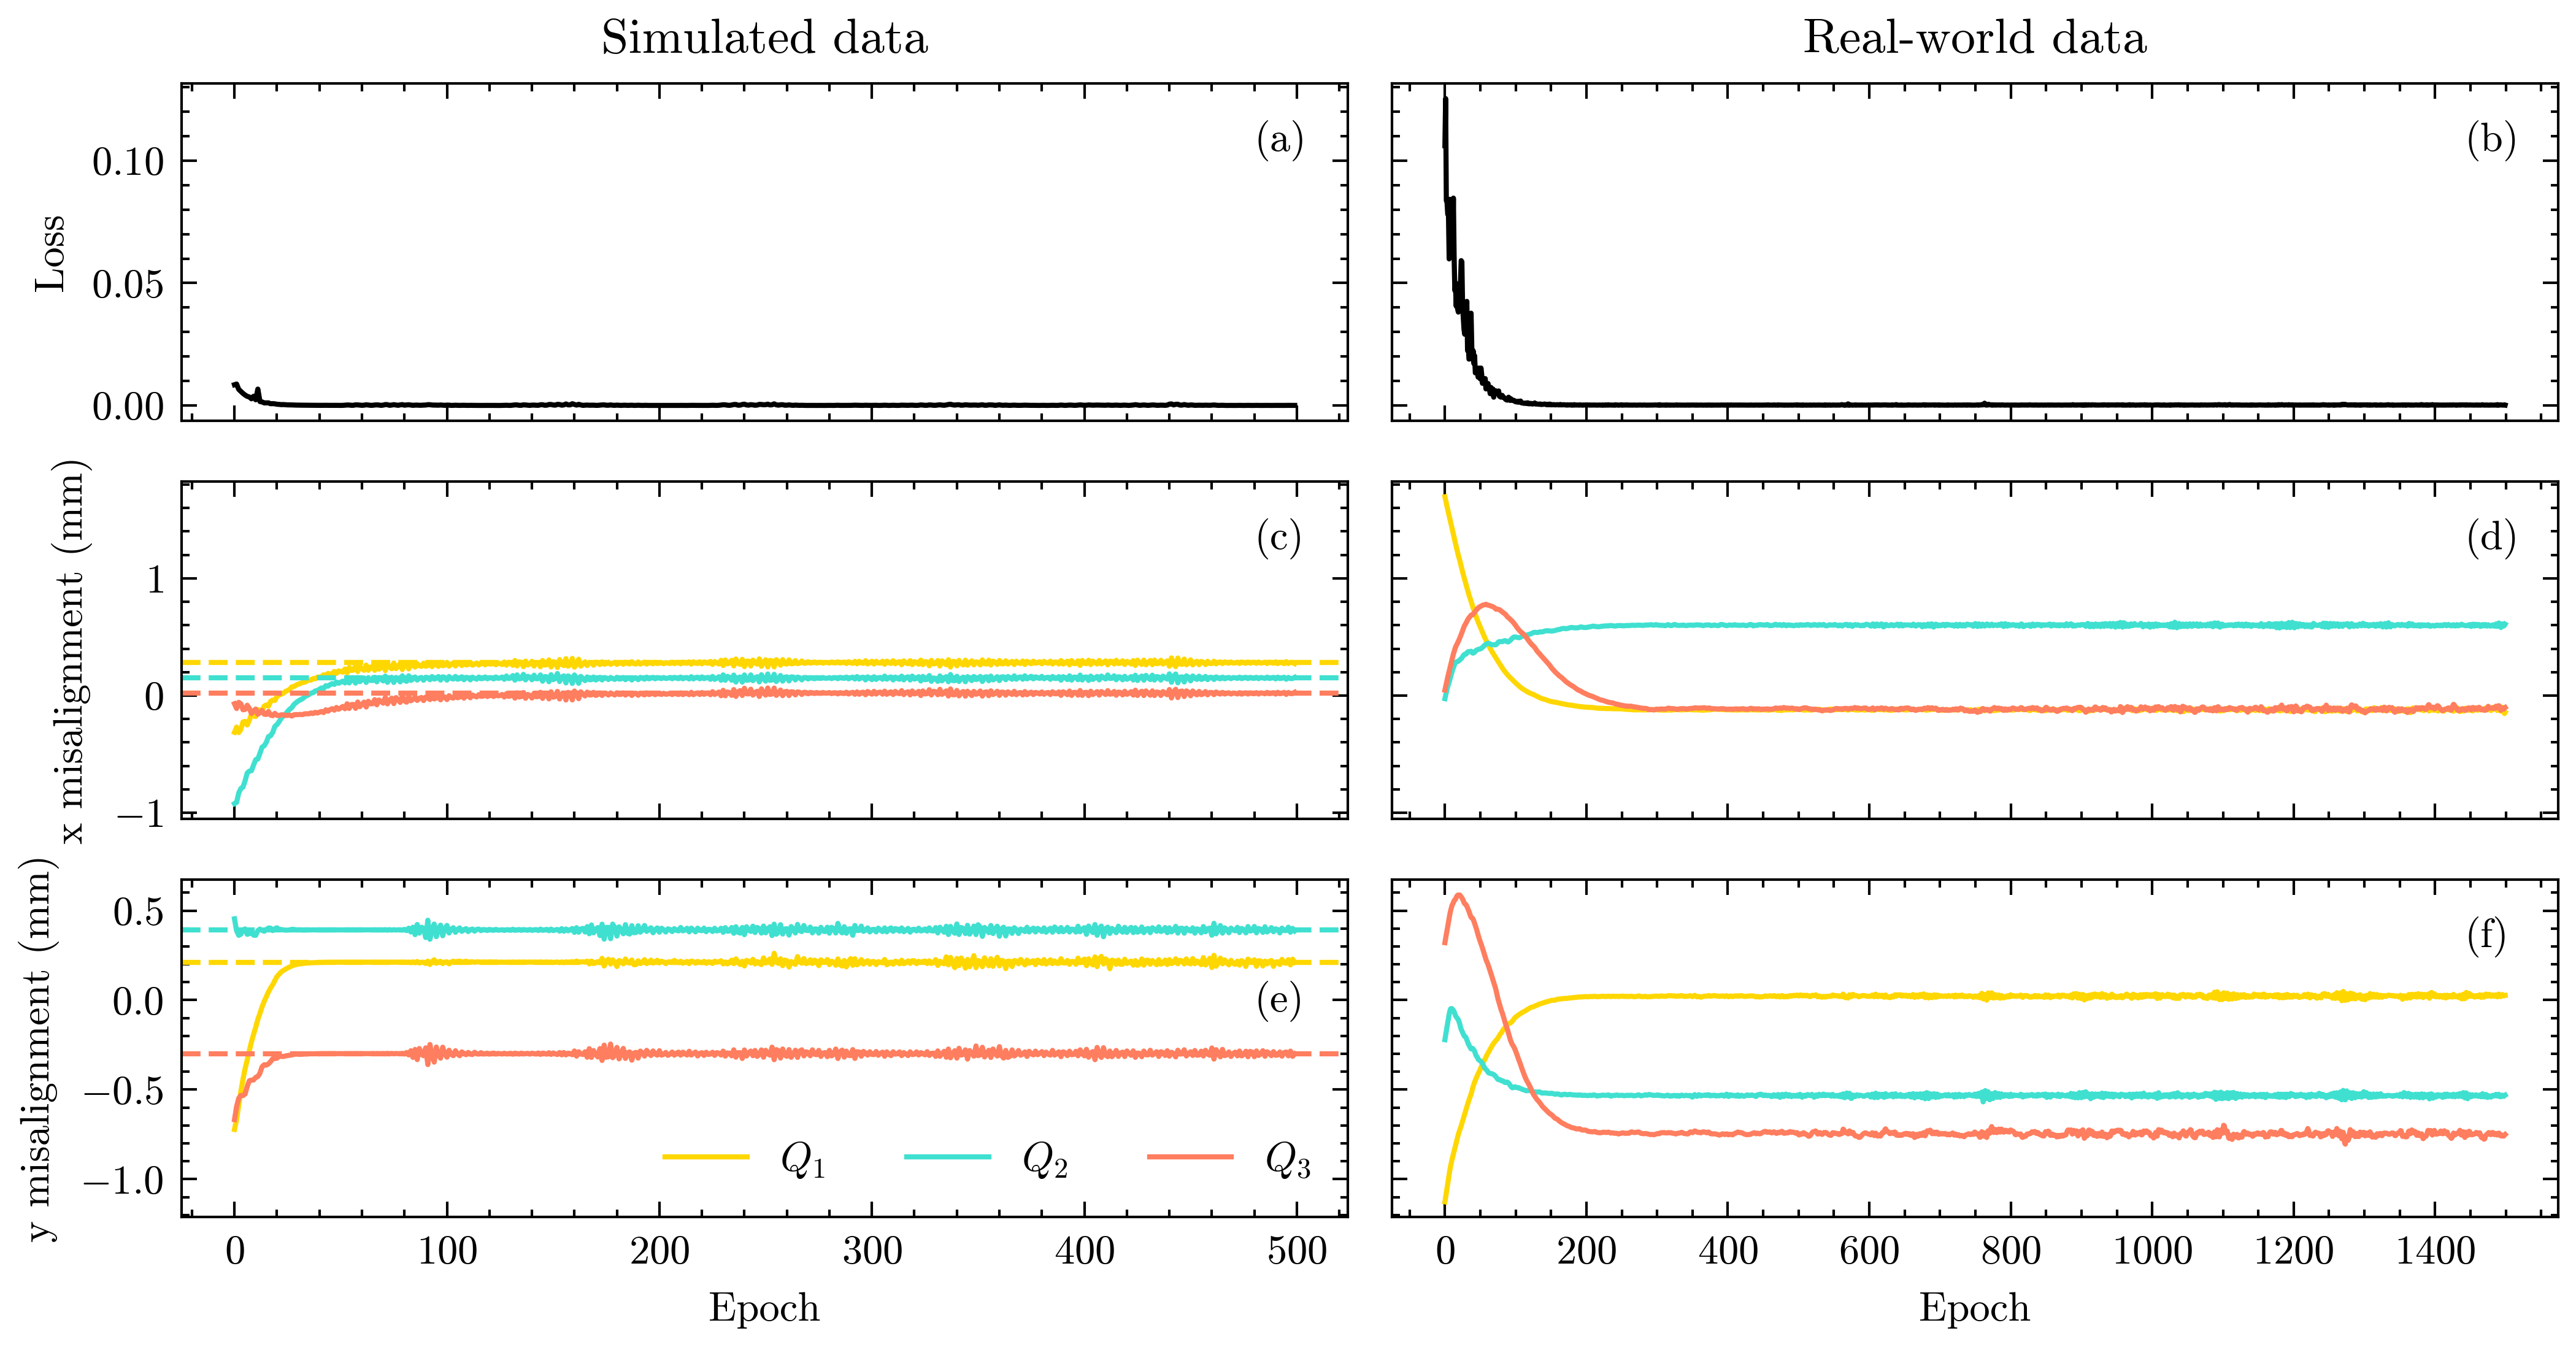

In [32]:
plot_two_trainings(
    history_a=history_7,
    history_b=history_2,
    ground_truth_a=rl_data_sim["observations"][0]["misalignments"],
    title_a="Simulated data",
    title_b="Real-world data",
    save_path="system_id_combined.pdf",
)

In [1]:
from typing import Dict, Optional

import cheetah
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import torch
import torch.nn as nn
from bo_cheetah_prior import simple_fodo_problem
from matplotlib.colors import LogNorm, Normalize
from xopt import VOCS

In [2]:
# Plotting Styles
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.style.use(["science", "ieee", "no-latex"])

In [3]:
# Load Data
df_nm = pd.read_csv("data/NM_matched.csv")
df_nm_mismatched = pd.read_csv("data/NM_mismatched.csv")
df_bo_matched = pd.read_csv("data/BO_matched.csv")
df_bo_mismatched = pd.read_csv("data/BO_mismatched.csv")
df_bo_prior_matched = pd.read_csv("data/BO_prior_matched.csv")
df_bo_prior_mismatched = pd.read_csv("data/BO_prior_mismatched.csv")
df_bo_prior_matched_newtask = pd.read_csv("data/BO_prior_matched_prior_newtask.csv")

## Grid Scan for true minimum


In [4]:
# Grid Scan to get the true minimum (for both matched and mismatched)
vocs_config = """ 
    variables:
        q1: [-30, 15]
        q2: [-15, 30]
    objectives:
        mae: minimize
"""
vocs = VOCS.from_yaml(vocs_config)
n_points = 50
xs = np.linspace(
    vocs.variables["q1"][0], vocs.variables["q1"][1], n_points, dtype=np.float32
)
ys = np.linspace(
    vocs.variables["q2"][0], vocs.variables["q2"][1], n_points, dtype=np.float32
)

X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
Z_mismatched = np.zeros_like(X)
for i in range(n_points):
    for j in range(n_points):
        Z[i, j] = simple_fodo_problem(
            {
                "q1": X[i, j],
                "q2": Y[i, j],
            }
        )["mae"]
        Z_mismatched[i, j] = simple_fodo_problem(
            {
                "q1": X[i, j],
                "q2": Y[i, j],
            },
            lattice_distances={
                "drift_length": 0.7,
            },
        )["mae"]

In [5]:
min_idx_original = np.unravel_index(np.argmin(Z), Z.shape)
min_idx_mismatched = np.unravel_index(np.argmin(Z_mismatched), Z_mismatched.shape)
best_original_in_mismatched = simple_fodo_problem(
    {
        "q1": float(X[min_idx_original]),
        "q2": float(Y[min_idx_original]),
    },
    # incoming_beam=mismatched_incoming_beam,
    lattice_distances={
        "drift_length": 0.7,
    },
)
print(best_original_in_mismatched)

{'mse': array(1.5546661e-06, dtype=float32), 'log_mse': array(-13.374249, dtype=float32), 'mae': array(0.00092902, dtype=float32), 'log_mae': array(-6.981385, dtype=float32)}


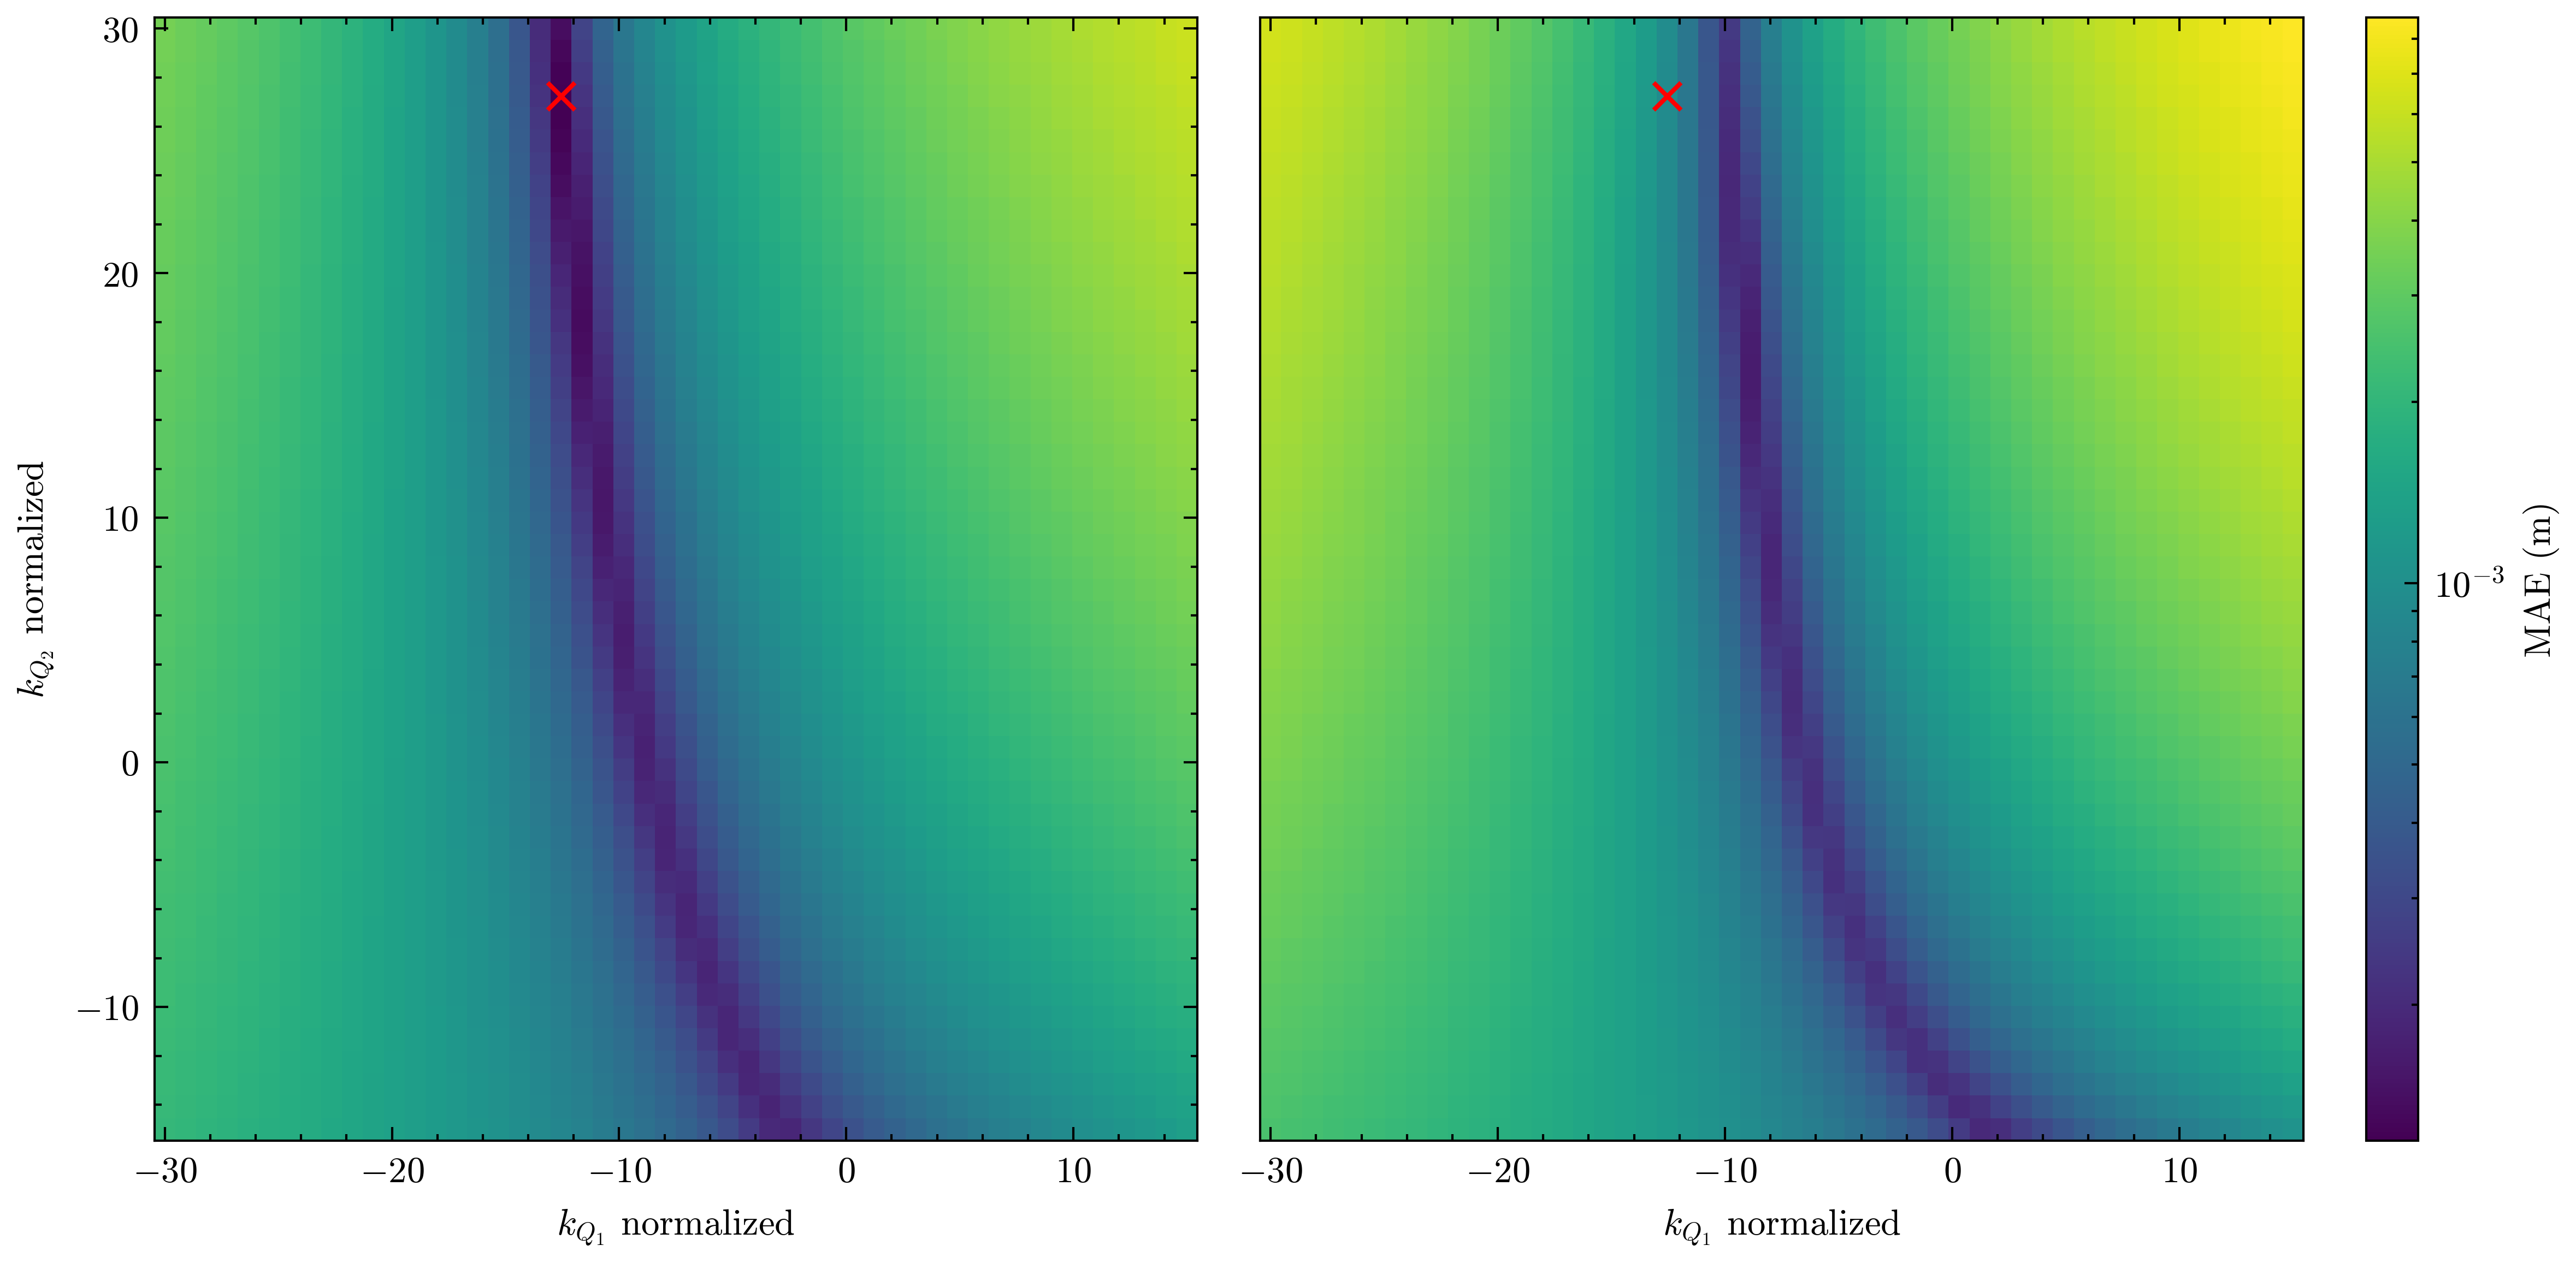

In [6]:
# plt.contourf(X, Y, Z)
fig, axes = plt.subplots(
    1, 3, figsize=(8, 4), gridspec_kw={"width_ratios": [1, 1, 0.05]}
)
vmin = np.min([Z.min(), Z_mismatched.min()])
vmax = np.max([Z.max(), Z_mismatched.max()])
# color_norm = Normalize(vmin=vmin, vmax=vmax)
color_norm = LogNorm(vmin=vmin, vmax=vmax)
cbar = axes[0].pcolormesh(X, Y, Z, norm=color_norm)
axes[1].pcolormesh(X, Y, Z_mismatched, norm=color_norm)
axes[0].set_ylabel(r"$k_{Q_2}$ normalized")
axes[1].set_xlabel(r"$k_{Q_1}$ normalized")
axes[1].set_yticks([])
axes[0].scatter(X[min_idx_original], Y[min_idx_original], marker="x", color="red")
axes[1].scatter(X[min_idx_original], Y[min_idx_original], marker="x", color="red")
for ax in axes[:2]:
    ax.set_xlabel(r"$k_{Q_1}$ normalized")
    # ax.set_xticks([-30, 15])
    # ax.set_xticklabels([0,1])

plt.colorbar(cbar, cax=axes[2], label="MAE (m)")
fig.tight_layout()

## Final Plot


In [7]:
# Version 1

# figsize = list(plt.rcParams["figure.figsize"])
# figsize[1] *= 1.4
# fig, [ax1, ax2] = plt.subplots(2, 1,figsize=figsize, sharex=True)

# # Matched Case
# sns.lineplot(data=df_nm, x="step", y="best_mae", ax=ax1, label="Simplex", color=colors[0], ls="-")
# sns.lineplot(data=df_bo_matched, x="step", y="best_mae", ax=ax1, label="BO", color=colors[1], ls="-.")
# sns.lineplot(data=df_bo_prior_matched, x="step", y="best_mae", ax=ax1, label="BO w. prior", color=colors[2], ls="--")
# ax1.axhline(y=Z.min(), color="grey", linestyle=":", label="True min.")

# # Mis-matched Case
# sns.lineplot(data=df_nm_mismatched, x="step", y="best_mae", ax=ax2, label="Simplex", color=colors[0], ls="-")
# sns.lineplot(data=df_bo_mismatched, x="step", y="best_mae", ax=ax2, label="BO", color=colors[1], ls="-.")
# sns.lineplot(data=df_bo_prior_mismatched, x="step", y="best_mae", ax=ax2, label="BO w. prior", color=colors[2], ls="--")
# ax2.axhline(y=best_original_in_mismatched["mae"], color="grey", linestyle=":", label="Mismatched Min.")
# ax2.axhline(y=Z_mismatched.min(), color="grey", linestyle=":", label="True min.")
# ax2.text(0.7, 0.5, "Min. of mismatched prior", transform=ax2.transAxes, color="grey", ha="center", fontdict={"size": 8})

# ax1.set_title("(a) Matched prior mean")
# ax2.set_title("(b) Mismatched prior mean")

# for ax in [ax1, ax2]:
#     yticks = ax.get_yticks()[1:]
#     ax.set_yticks(ticks=yticks)
#     ax.set_yticklabels(labels=1000 * yticks)
#     ax.set_ylabel("Beam size (mm)")
#     ax.set_xlim(0, 50)
#     ax.get_legend().remove()
# ax2.set_xlabel("Iteration")

# # align y label
# fig.align_ylabels()
# handles, labels = ax1.get_legend_handles_labels()
# # Plot the legend vertically on the right side of the plot
# fig.legend(handles, labels, loc='upper right', ncols=4)
# fig.subplots_adjust(top=0.87, bottom=0.1, left=0.1, right=0.9, hspace=0.25)
# fig.savefig("../figures/bo_cheetah_prior_result.pdf", bbox_inches="tight")

### Final Plot version 2


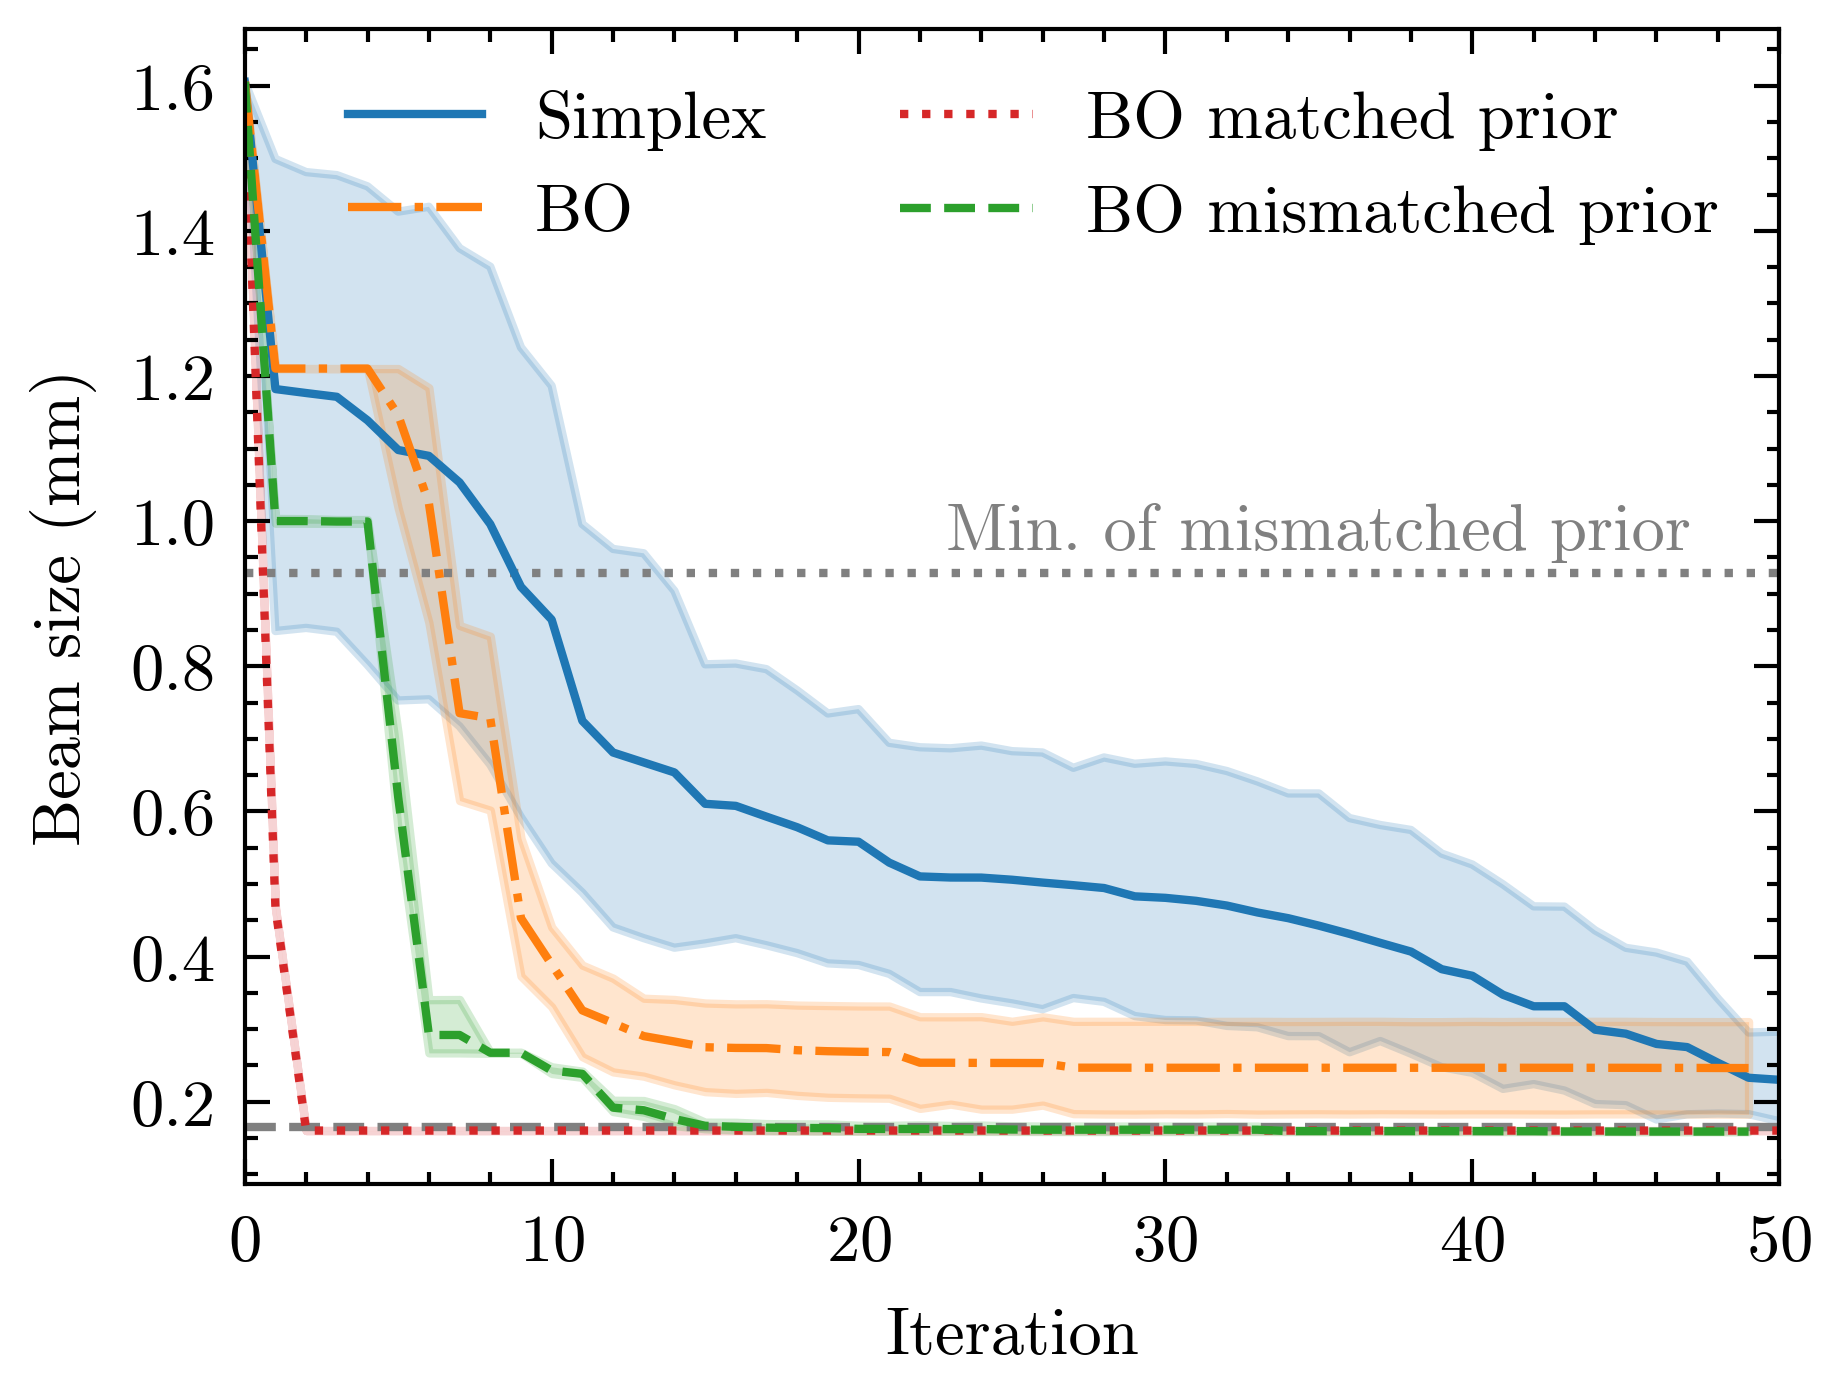

In [8]:
figsize = list(plt.rcParams["figure.figsize"])
fig = plt.figure(figsize=figsize)
ax = plt.gca()

ax.axhline(y=best_original_in_mismatched["mae"], color="grey", linestyle=":")
ax.axhline(y=Z_mismatched.min(), color="grey", linestyle="--")
sns.lineplot(
    data=df_nm_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="Simplex",
    color=colors[0],
    ls="-",
)
sns.lineplot(
    data=df_bo_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO",
    color=colors[1],
    ls="-.",
)
sns.lineplot(
    data=df_bo_prior_matched_newtask,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO matched prior",
    color=colors[3],
    ls=":",
)
sns.lineplot(
    data=df_bo_prior_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO mismatched prior",
    color=colors[2],
    ls="--",
)

ax.text(
    0.7,
    0.55,
    "Min. of mismatched prior",
    transform=ax.transAxes,
    color="grey",
    ha="center",
    fontdict={"size": 8},
)

yticks = ax.get_yticks()[1:]
ax.set_yticks(np.arange(0.2, 1.8, 0.2) * 1e-3)
ax.set_yticklabels(
    np.arange(0.2, 1.8, 0.2).round(2)
)  # Remove numerical error in the labels
# ax.set_yticks(ticks=yticks)
# ax.set_yticklabels(labels=1000 * yticks)
# from matplotlib.ticker import FormatStrFormatter, FuncFormatter
# def y_fmt(tick_val, pos):
#     return tick_val * 1000
# ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylabel("Beam size (mm)")
ax.set_xlabel("Iteration")
ax.set_xlim(0, 50)
ax.legend(ncol=2)
# ax.get_legend().remove()
fig.savefig("bo_cheetah_prior_result.pdf", bbox_inches="tight")